# Supervised Learning - Assignment nº 2
## Loan Approval Prediction


### Description
The goal is to develop a machine learning model that predicts if a loan application is approved or not. 

The target variable is loan_status, a binary label where 1 indicates the loan is approved and 0 means it is not.

The dataset provided for training and testing was generated from a deep learning model trained on the Loan Approval Prediction dataset.

#### Files

- **train.csv**: Contains the training data, including the target variable loan_status.

- **test.csv**: Test data where the task is to predict the probability of loan approval (loan_status).

### Import libraries
Before running the notebook, make sure all the necessary libraries are installed.

This project includes a `requirements.txt` file that lists all dependencies.

To install them, run the following command in your terminal: ` pip install -r requirements.txt `

In [53]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statistics
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV

import sklearn.tree as tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectKBest, RFE, f_classif
from sklearn.pipeline import Pipeline

from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

from tensorflow import keras
from tensorflow.keras import layers

from xgboost import XGBClassifier

warnings.filterwarnings('ignore')

### Loading the Training Data

In [54]:
data = pd.read_csv('train.csv')

### Exploratory Data Analysis 

#### General infomation

In [55]:
print("Dataset info:")
print(data.info())
print("\n")

print("Status:")
print(data['loan_status'].unique())
print("\n")

print("First 5 rows of the dataset:")
print(data.head())
print("\n")

print("Summary statistics:")
print(data.describe())

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), in

#### Distribution of target variable


--- Distribution of target variable ---
loan_status
0   85.762
1   14.238
Name: proportion, dtype: float64


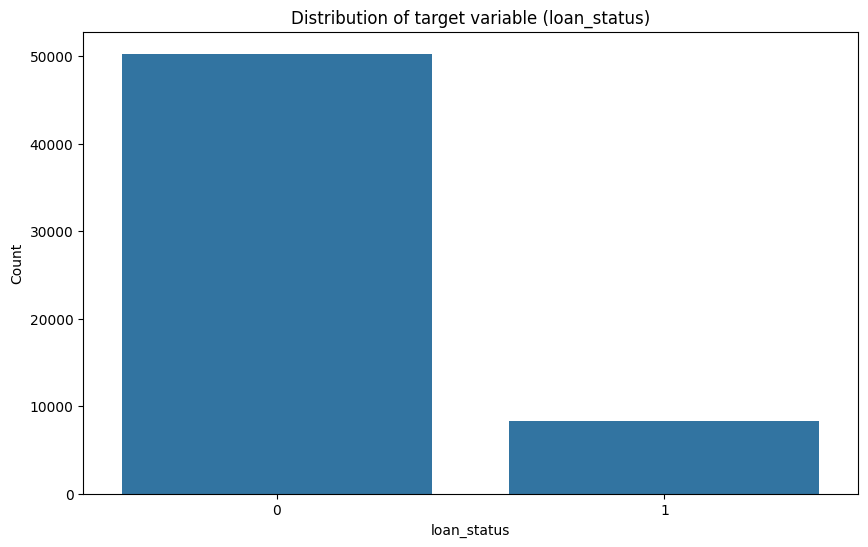

In [56]:
print("\n--- Distribution of target variable ---")
loan_status_counts = data['loan_status'].value_counts(normalize=True) * 100
print(loan_status_counts)

plt.figure(figsize=(10, 6))
sns.countplot(x='loan_status', data=data)
plt.title('Distribution of target variable (loan_status)')
plt.ylabel('Count')
plt.show()

### Data preprocessing 
#### Missing values

In [57]:
print("\n--- Missing values ---")
missing_values = data.isnull().sum()
print(missing_values)

print("\nRows containing missing values:")
print(data[data.isnull().any(axis=1)])


--- Missing values ---
id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

Rows containing missing values:
Empty DataFrame
Columns: [id, person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length, loan_status]
Index: []


#### 

#### Correlation of atributes

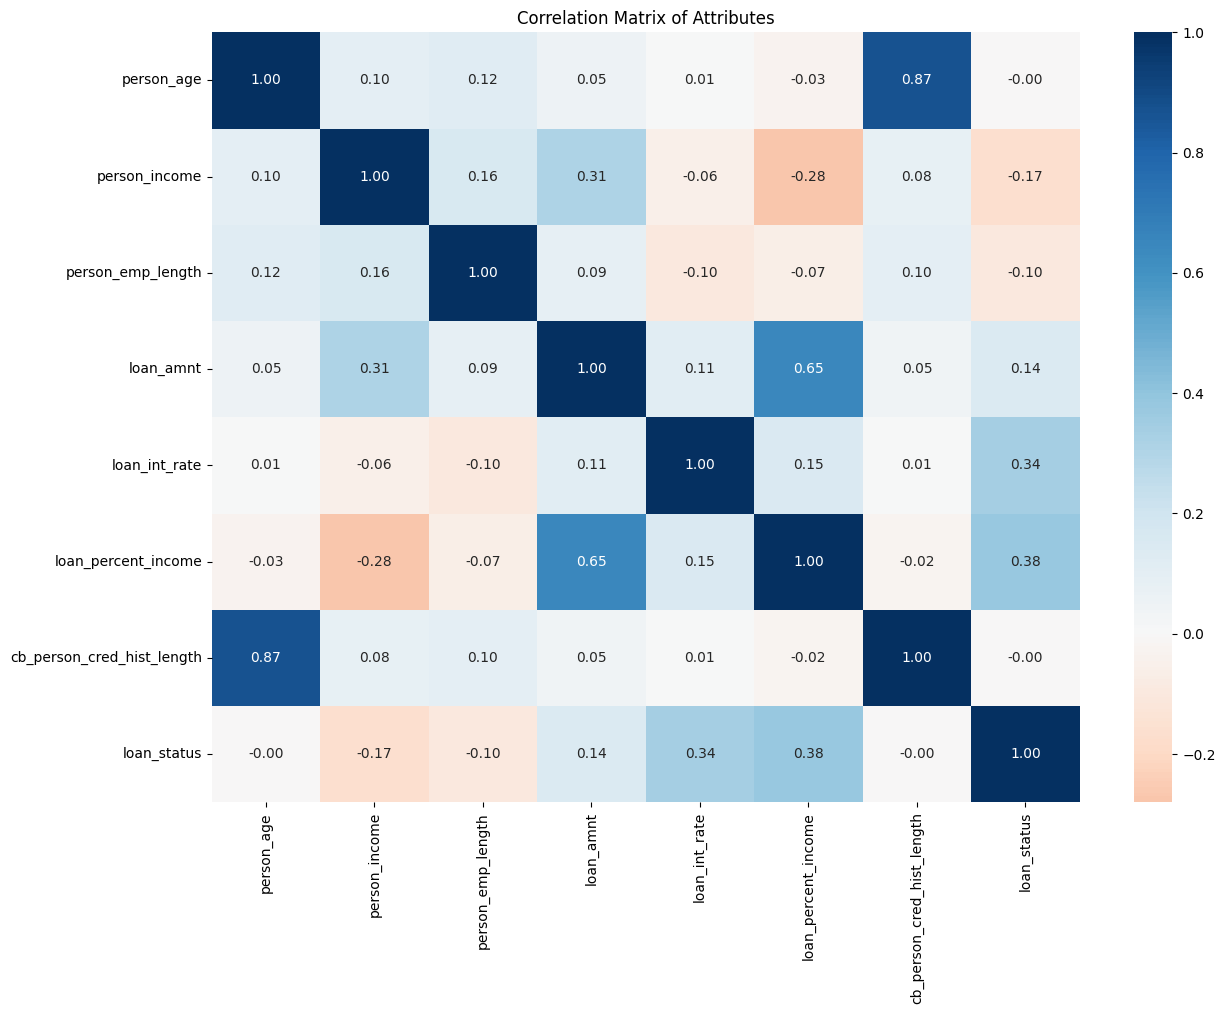

In [58]:
data_encoded = pd.get_dummies(data.drop(columns=["id", "person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"]))

correlation_matrix = data_encoded.corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdBu', center=0)
plt.title("Correlation Matrix of Attributes")
plt.show()

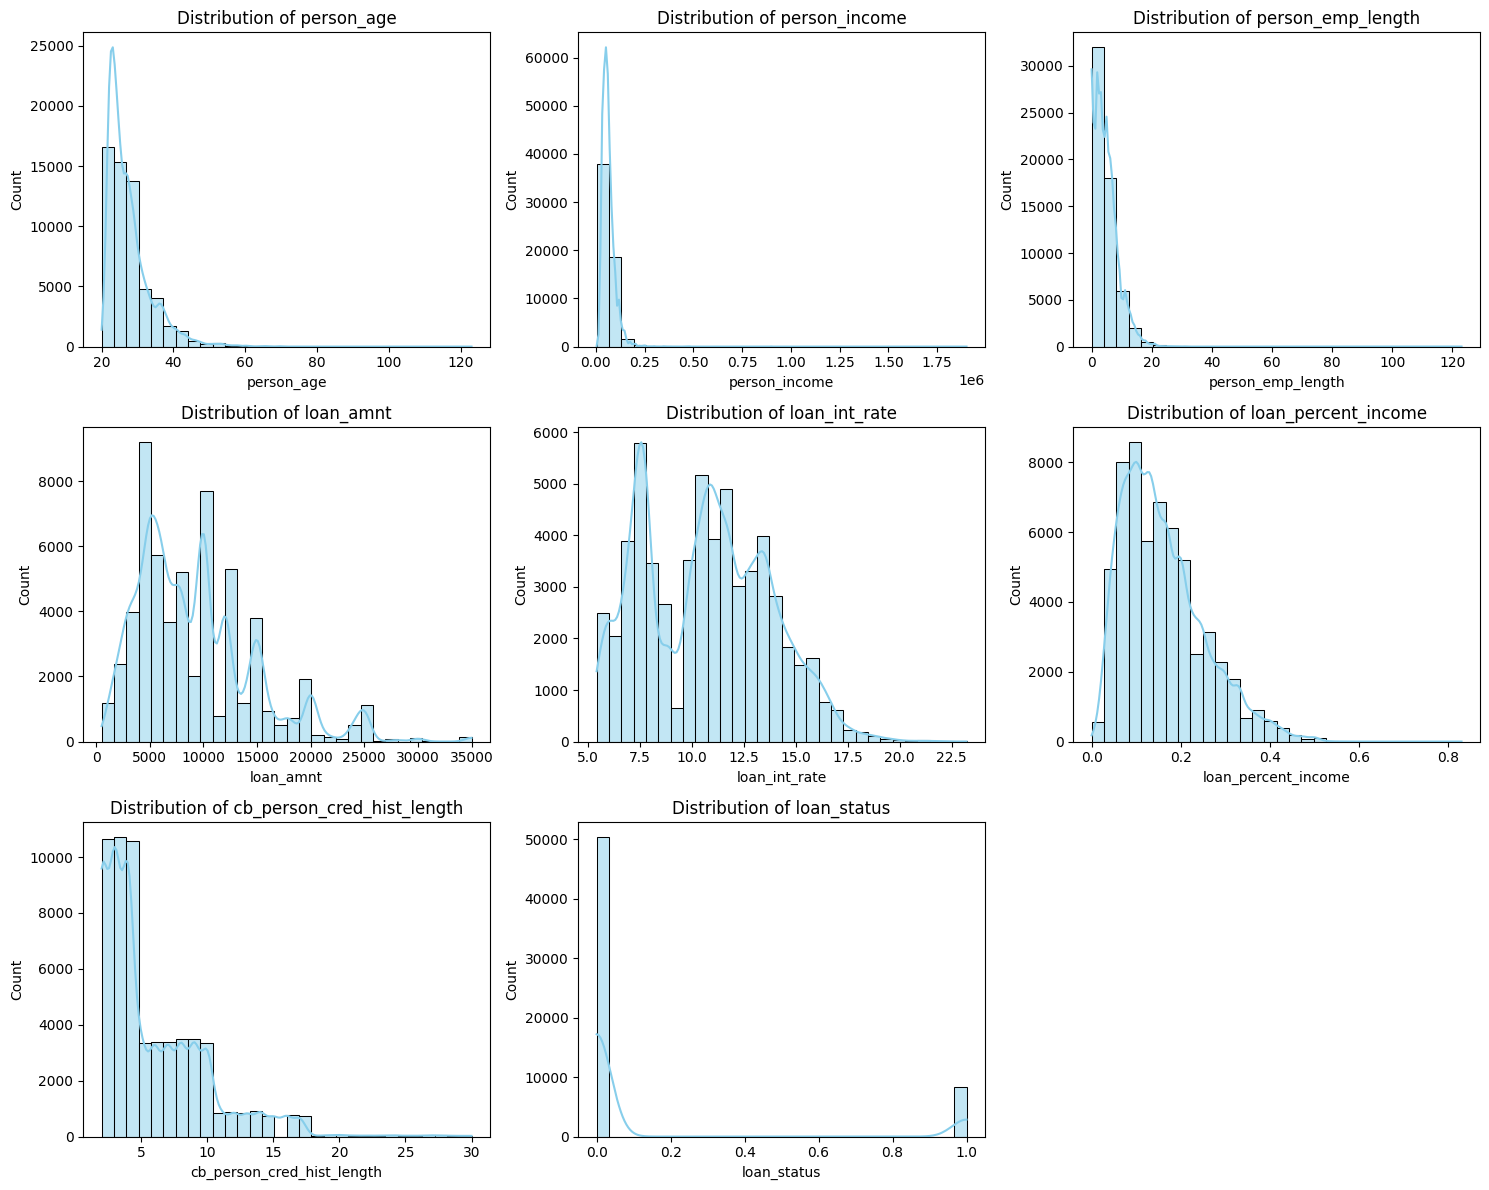

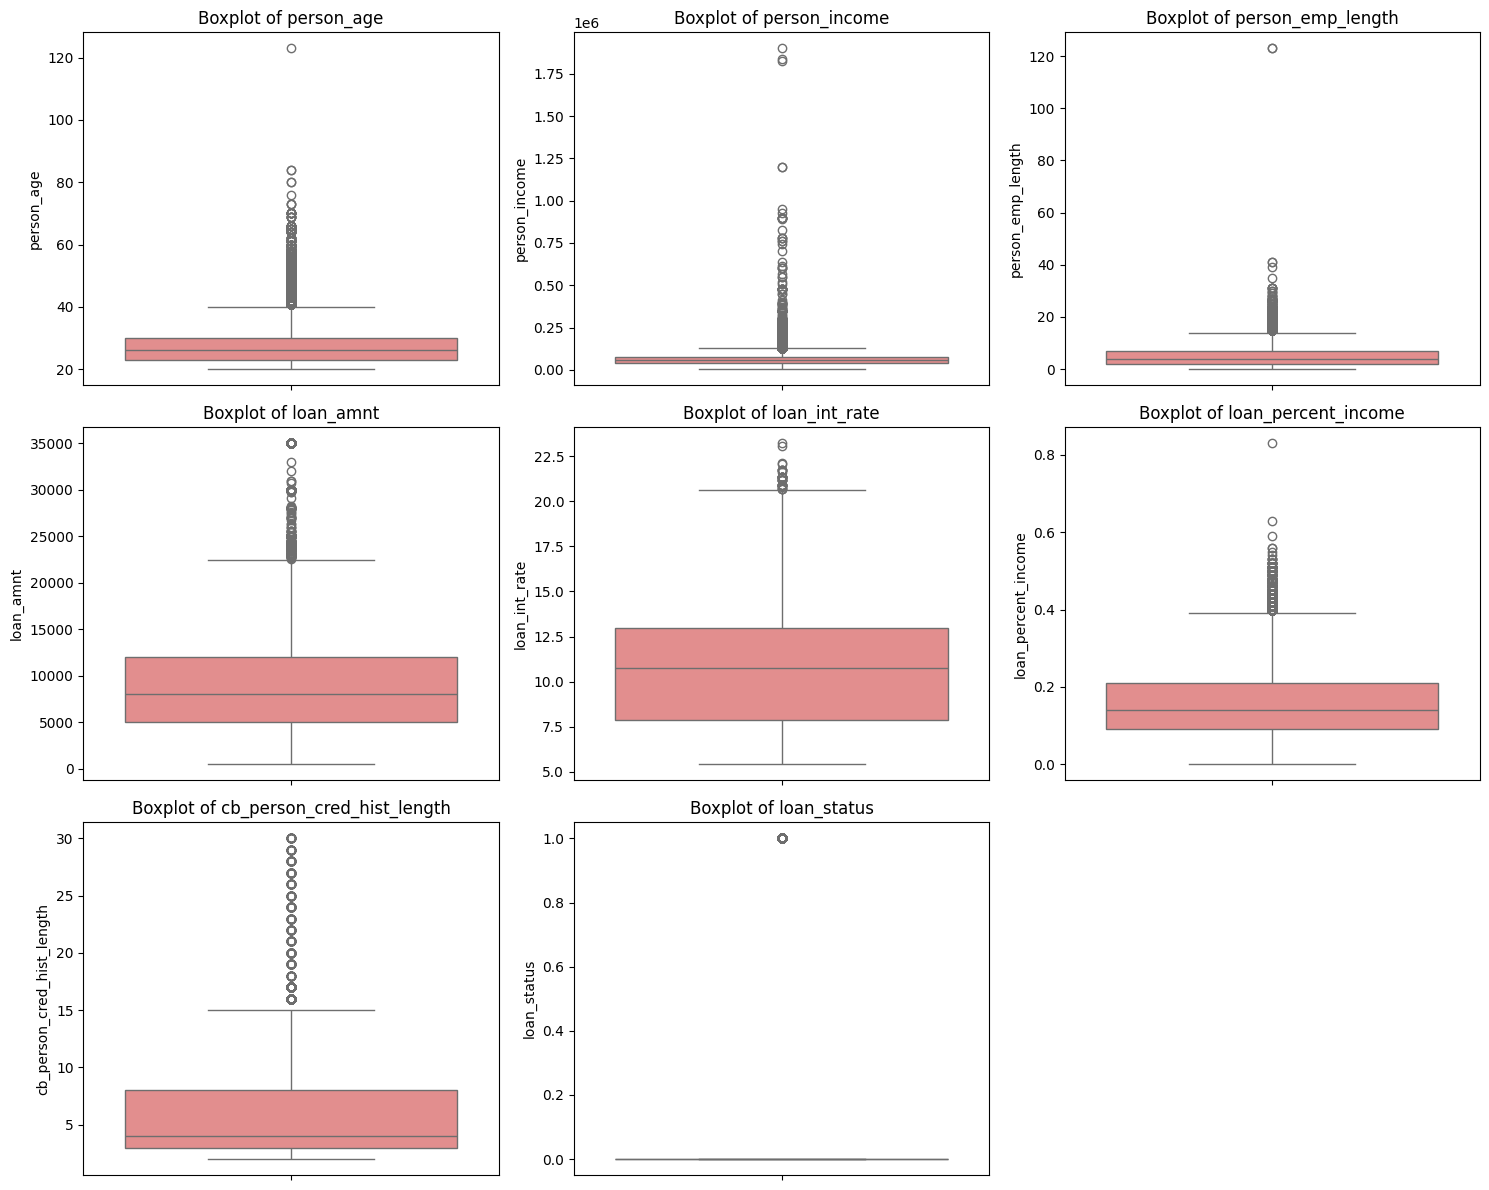

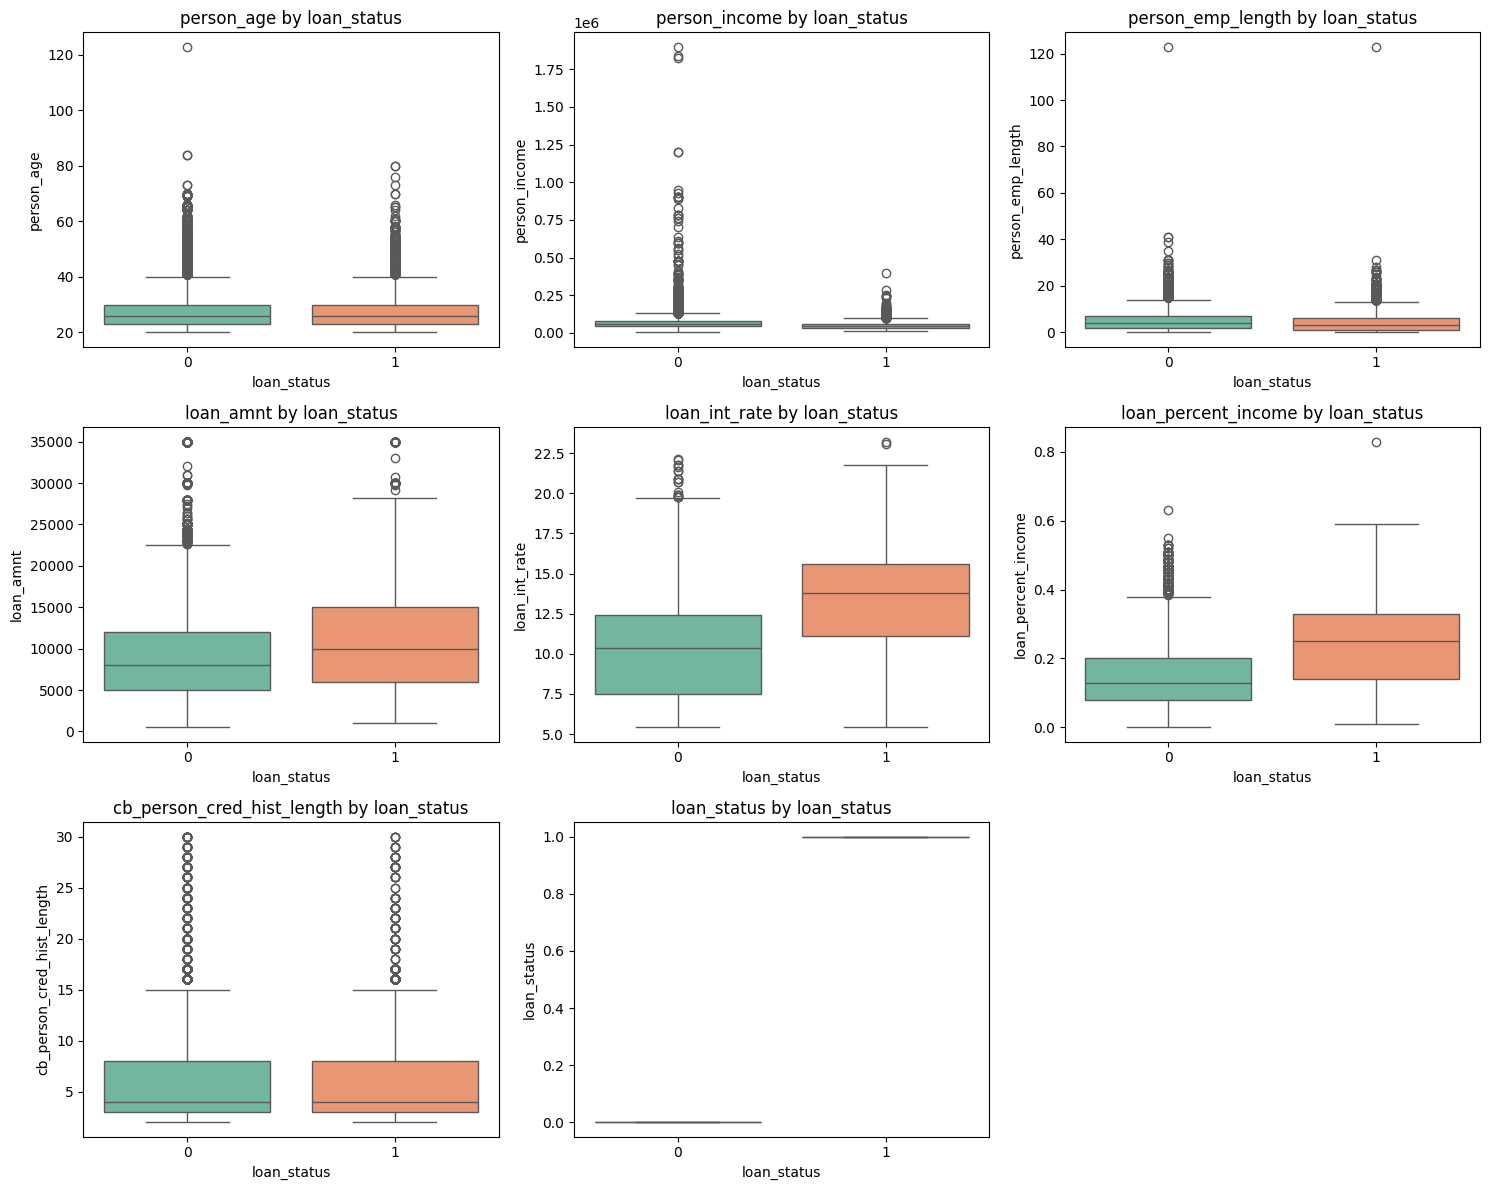

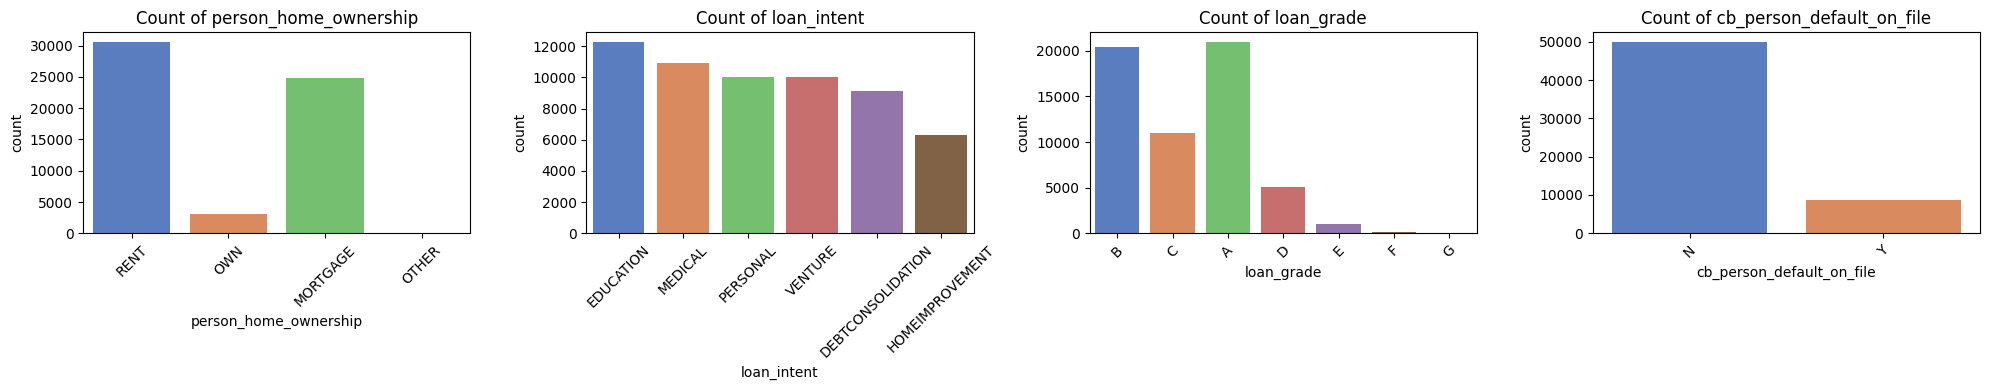

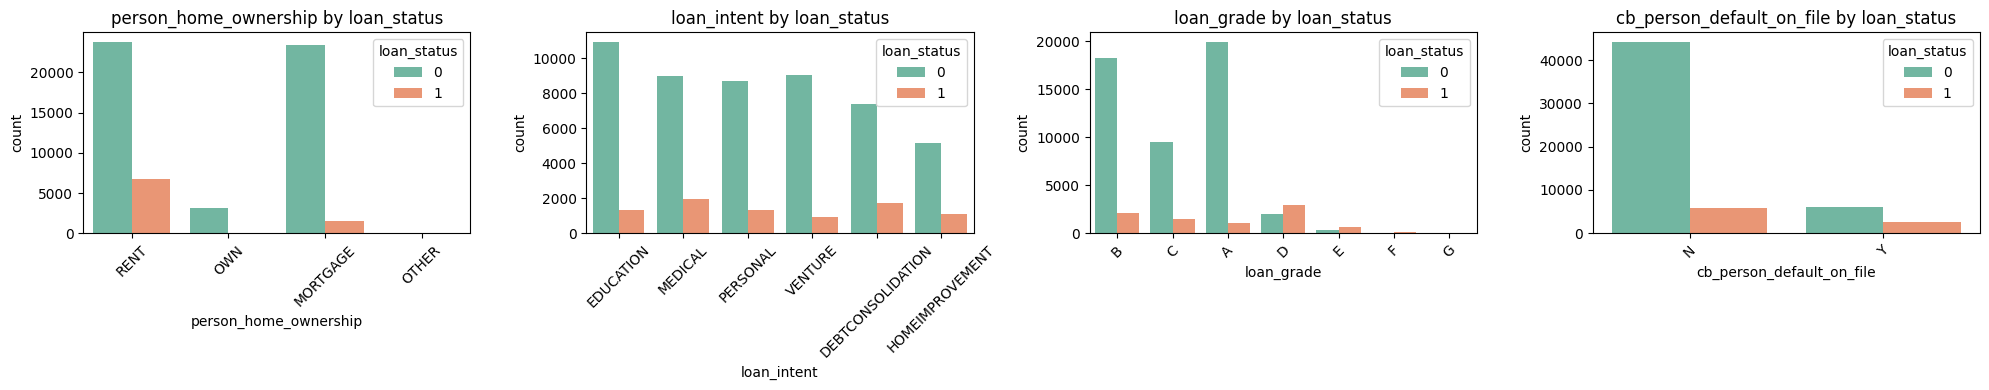

In [59]:
def plot_numeric_distributions(data, numeric_cols, cols_per_row=3, bins=30):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.histplot(data[col], ax=axes[i], kde=True, bins=bins, color='skyblue')
        axes[i].set_title(f'Distribution of {col}')

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_numeric_boxplots(data, numeric_cols, cols_per_row=3):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(y=data[col], ax=axes[i], color='lightcoral')
        axes[i].set_title(f'Boxplot of {col}')
    
    # Remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_numeric_boxplots_by_target(data, numeric_cols, target_col, cols_per_row=3):
    rows = (len(numeric_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(numeric_cols):
        sns.boxplot(x=target_col, y=col, data=data, ax=axes[i], hue=target_col, palette='Set2', legend=False)
        axes[i].set_title(f'{col} by {target_col}')
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


def plot_categorical_columns(data, categorical_cols, cols_per_row=4):
    rows = (len(categorical_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, hue=col, data=data, ax=axes[i], palette='muted', legend=False)
        axes[i].set_title(f'Count of {col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

def plot_categorical_columns_by_target(data, categorical_cols, target_col='loan_status', cols_per_row=4):
    rows = (len(categorical_cols) + cols_per_row - 1) // cols_per_row
    fig, axes = plt.subplots(rows, cols_per_row, figsize=(5 * cols_per_row, 4 * rows))
    axes = axes.flatten()

    for i, col in enumerate(categorical_cols):
        sns.countplot(x=col, hue=target_col, data=data, ax=axes[i], palette='Set2')
        axes[i].set_title(f'{col} by {target_col}')
        axes[i].tick_params(axis='x', rotation=45)
    
    # Remove eixos não utilizados
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()


numeric_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
numeric_cols.remove('id')  # Se não quiseres o 'id'
categorical_cols = data.select_dtypes(include=['object']).columns.tolist()

# Plots
plot_numeric_distributions(data, numeric_cols)
plot_numeric_boxplots(data, numeric_cols)
plot_numeric_boxplots_by_target(data, numeric_cols, target_col='loan_status')
plot_categorical_columns(data, categorical_cols)
plot_categorical_columns_by_target(data, categorical_cols, target_col='loan_status')

### Preparation of data

In [ ]:
# Convert categorical variables to numerical
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])

# Convert boolean values to integers
data = data.astype({col: int for col in data.select_dtypes(include=['bool']).columns})

all_inputs = data.drop(columns=["loan_status", "id"]).values
all_labels = data["loan_status"].values

# Normalize the data
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

# Check the dtype of all_inputs
print(all_inputs.dtype)


# Supervised Learning Algorithms

## Decision Tree

### 100 Repetitions default run

Accuracy: 0.9129


Text(0, 0.5, 'Frequency')

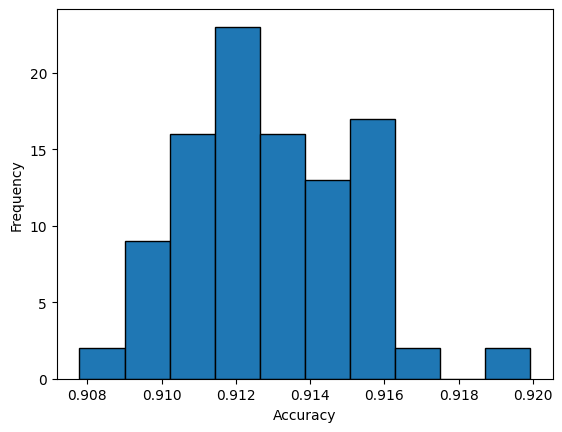

In [61]:
model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    decision_tree_classifier = DecisionTreeClassifier(random_state=1)
    decision_tree_classifier.fit(training_inputs, training_classes)
    predicted_classes = decision_tree_classifier.predict(testing_inputs)
    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

average_accuracy = statistics.mean(model_accuracies)
print(f"Accuracy: {average_accuracy:.4f}")

plt.hist(model_accuracies, edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

### Decision tree with k-fold

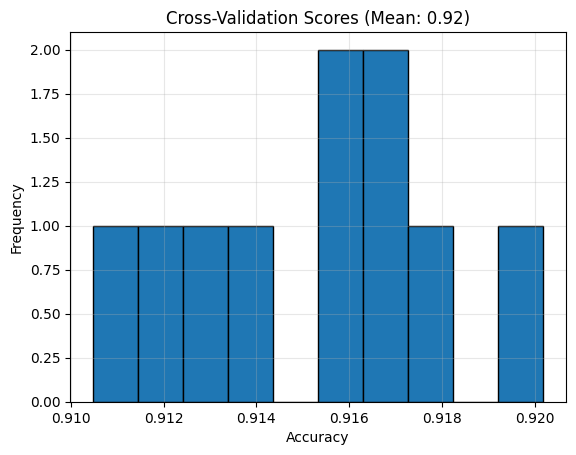

[0.91202046 0.91679454 0.91594203 0.91321398 0.91645354 0.920191
 0.91558663 0.91746248 0.91388131 0.91047067]
Average accuracy across 10 folds: 0.9152


In [ ]:
decision_tree_classifier = DecisionTreeClassifier()

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
cv_scores = cross_val_score(decision_tree_classifier, all_inputs, all_labels, cv=stratified_kfold)

plt.hist(cv_scores, bins=10, edgecolor='black')
plt.title(f'Cross-Validation Scores (Mean: {np.mean(cv_scores):.2f})')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

print(cv_scores)
print(f"Average accuracy across 10 folds: {np.mean(cv_scores):.4f}")

Here we observe a small improvement compared to the default Decision Tree run. This improvement is due to the use of StratifiedKFold, which ensures that each fold used during cross-validation maintains the same class distribution as the original dataset. This leads to a more balanced and representative evaluation, especially when the classes are imbalanced, and helps the model generalize better across all data splits.

### Find best performing parameters for Decision Tree with k-fold (just max depth and max features)

Best score: 0.9463209939649386
Best parameters: {'max_depth': 9, 'max_features': 11}


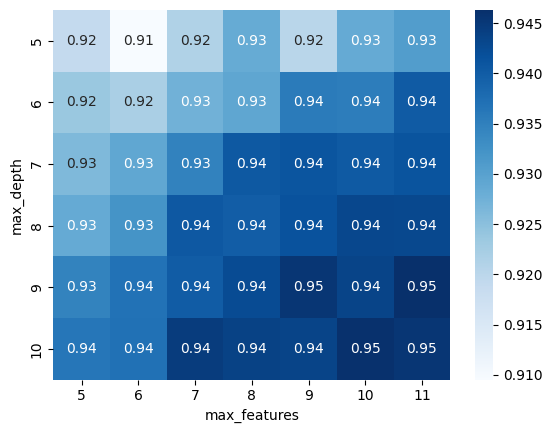

In [37]:

decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10],
    'max_features': [5, 6, 7, 8, 9, 10, 11],
}

cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
grid_search = GridSearchCV(
    estimator=decision_tree_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)
grid_search.fit(all_inputs, all_labels)

grid_visualization = grid_search.cv_results_['mean_test_score']
grid_visualization.shape = (len(parameter_grid['max_depth']), len(parameter_grid['max_features']))

sns.heatmap(grid_visualization, cmap='Blues', annot=True)
plt.xticks(np.arange(len(parameter_grid['max_features'])) + 0.5, parameter_grid['max_features'])
plt.yticks(np.arange(len(parameter_grid['max_depth'])) + 0.5, parameter_grid['max_depth'])
plt.xlabel('max_features')
plt.ylabel('max_depth')

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))



Here we can see that adding more features and allowing greater tree depth clearly improves the performance of the Decision Tree.
This happens because:
    - More features provide more information
    - Increasing the depth of the tree allows it to model more complex relationships in the data

### Find best performing parameters for Decision Tree with k-fold

In [ ]:
decision_tree_classifier = DecisionTreeClassifier()

parameter_grid = {'criterion': ['gini', 'entropy'],
                  'splitter': ['best', 'random'],
                    'max_depth': [5, 6, 7, 8, 9, 10],
                        'max_features': [5, 6, 7, 8, 9, 10, 11]}

cross_validation = StratifiedKFold(n_splits=10)

grid_search = GridSearchCV(decision_tree_classifier,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(all_inputs, all_labels)
print('Best score: {}'.format(grid_search.best_score_))
DecisionTree_bestScore = grid_search.best_score_
print('Best parameters: {}'.format(grid_search.best_params_))

decision_tree_classifier = grid_search.best_estimator_

with open('loan_tree.dot', 'w') as out_file:
    out_file = tree.export_graphviz(decision_tree_classifier, out_file=out_file)

Best score: 0.9470032559556831
Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 11, 'splitter': 'best'}


### Statistics
### Plot Roc Curve for best parameters

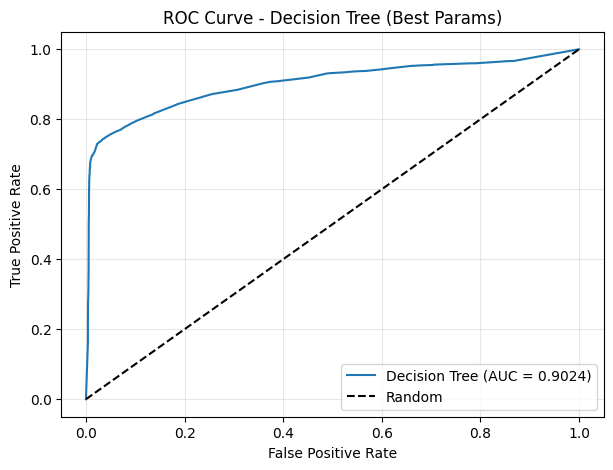

In [ ]:
training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

best_tree = grid_search.best_estimator_
best_tree.fit(training_inputs, training_classes)

y_proba = best_tree.predict_proba(testing_inputs)[:, 1]

fpr, tpr, thresholds = roc_curve(testing_classes, y_proba)
DecisionTree_auc = roc_auc_score(testing_classes, y_proba)


plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {DecisionTree_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Decision Tree (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


### Learning curve (training and validation accuracy)

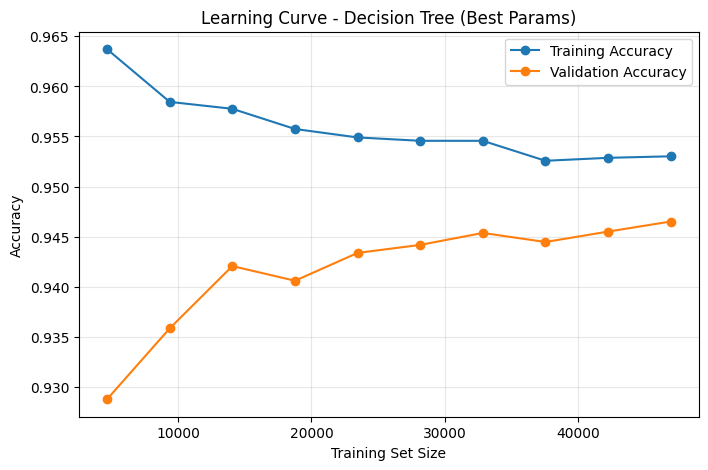

In [ ]:
best_tree = grid_search.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    best_tree,
    all_inputs, all_labels,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Decision Tree (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Precision

In [ ]:
training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

best_tree = grid_search.best_estimator_
best_tree.fit(training_inputs, training_classes)

y_pred = best_tree.predict(testing_inputs)

DecisionTree_precision = precision_score(testing_classes, y_pred)
print(f"Precision (Decision Tree with best parameters): {DecisionTree_precision:.4f}")

Precision (Decision Tree with best parameters): 0.9056


### Recall

In [62]:
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_tree = grid_search.best_estimator_

recall_scores = cross_val_score(
    best_tree,
    all_inputs,
    all_labels,
    cv=stratified_kfold,
    scoring='recall'
)

print("Recall scores for each fold (best params):", recall_scores)
print("Average recall across 10 folds (best params): {:.4f}".format(recall_scores.mean()))

DecisionTree_recall = recall_scores.mean()

Recall scores for each fold (best params): [0.67185629 0.69700599 0.70898204 0.70538922 0.68383234 0.71377246
 0.69101796 0.66107784 0.66586826 0.6742515 ]
Average recall across 10 folds (best params): 0.6873


### F1 

In [ ]:

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
best_tree = grid_search.best_estimator_

f1_scores = cross_val_score(
    best_tree,
    all_inputs,
    all_labels,
    cv=stratified_kfold,
    scoring='f1'
)

print("F1 scores for each fold (best params):", f1_scores)
print("Average F1-score across 10 folds (best params): {:.4f}".format(f1_scores.mean()))

DecisionTree_F1 = f1_scores.mean()

F1 scores for each fold (best params): [0.78825137 0.80519481 0.78940217 0.78527607 0.79007378 0.80647336
 0.79812207 0.79180887 0.75175316 0.75937287]
Average F1-score across 10 folds (best params): 0.7866


### Confusion Matrix

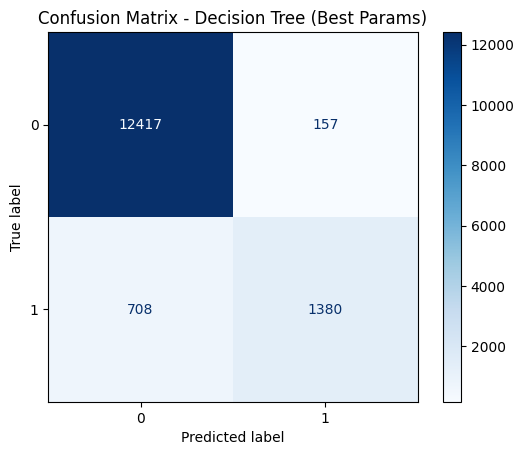

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=1
)

best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

y_pred = best_tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Decision Tree (Best Params)")
plt.show()

### RANDOM FOREST
Finding best parameters

Best RF score: 0.9512149373348111
Best RF params: {'max_depth': 10, 'max_features': 11, 'n_estimators': 100}


,param_n_estimators,mean_test_score,std_test_score
0,10,0.950,0.003
1,50,0.951,0.003
2,100,0.951,0.002
3,200,0.951,0.002
4,300,0.951,0.002
5,500,0.951,0.002
6,1000,0.951,0.002


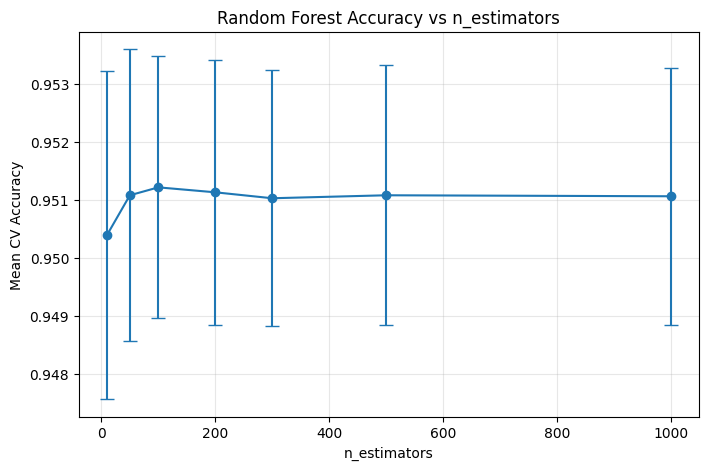

In [64]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100, 200, 300, 500, 1000],
    'max_depth': [10],
    'max_features': [11]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search_rf = GridSearchCV(rf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(all_inputs, all_labels)

print("Best RF score:", grid_search_rf.best_score_)
print("Best RF params:", grid_search_rf.best_params_)

RandomForest_score = grid_search_rf.best_score_

results = pd.DataFrame(grid_search_rf.cv_results_)
display(results[['param_n_estimators', 'mean_test_score', 'std_test_score']])

plt.figure(figsize=(8,5))
plt.errorbar(
    results['param_n_estimators'], 
    results['mean_test_score'], 
    yerr=results['std_test_score'], 
    fmt='o-', capsize=5
)
plt.xlabel('n_estimators')
plt.ylabel('Mean CV Accuracy')
plt.title('Random Forest Accuracy vs n_estimators')
plt.grid(True, alpha=0.3)
plt.show()

### Statistics
### Learning curve and Plot Roc Curve

Learning curve  (training and validation accuracy)

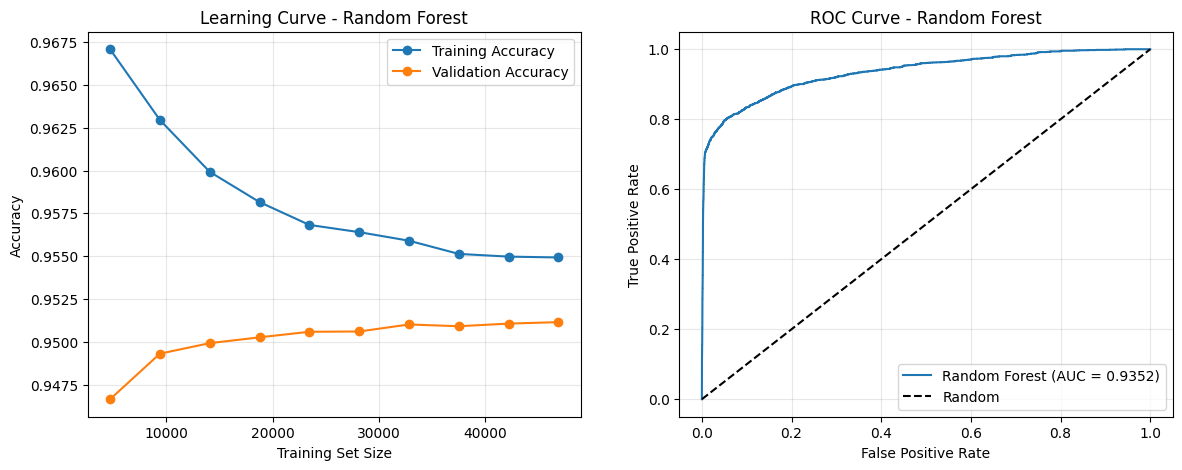

In [68]:
# Learning curve 
best_rf = grid_search_rf.best_estimator_
train_sizes, train_scores, val_scores = learning_curve(
    best_rf, all_inputs, all_labels, cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=42
)
train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)


# Plot Roc Curve
X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)
best_rf.fit(X_train, y_train)
y_proba = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
RandomForest_auc = roc_auc_score(y_test, y_proba)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
ax1.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
ax1.set_xlabel('Training Set Size')
ax1.set_ylabel('Accuracy')
ax1.set_title('Learning Curve - Random Forest')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(fpr, tpr, label=f'Random Forest (AUC = {RandomForest_auc:.4f})')
ax2.plot([0,1], [0,1], 'k--', label='Random')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve - Random Forest')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.show()


### Precision

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
precision_scores = []
best_rf = grid_search_rf.best_estimator_

for train_idx, test_idx in cv.split(all_inputs, all_labels):
    X_train, X_test = all_inputs[train_idx], all_inputs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)
    
print("Precision scores for each fold:", precision_scores)
print(f"Average precision across folds: {np.mean(precision_scores):.4f}")
print(f"Standard deviation of precision: {np.std(precision_scores):.4f}")
RandomForest_precision = np.mean(precision_scores)

Precision scores for each fold: [0.9253246753246753, 0.9347471451876019, 0.9388714733542319, 0.9509803921568627, 0.9379084967320261, 0.9503311258278145, 0.9522292993630573, 0.9415481832543444, 0.9439102564102564, 0.9383886255924171]
Average precision across folds: 0.9414
Standard deviation of precision: 0.0079


### Recall

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
recall_scores = []
best_rf = grid_search_rf.best_estimator_


for train_idx, test_idx in cv.split(all_inputs, all_labels):
    X_train, X_test = all_inputs[train_idx], all_inputs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)
    
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)

print("Recall scores for each fold:", recall_scores)
print(f"Average recall across folds: {np.mean(recall_scores):.4f}")
print(f"Standard deviation of recall: {np.std(recall_scores):.4f}")
RandomForest_recall = np.mean(recall_scores)


Recall scores for each fold: [0.6826347305389222, 0.6862275449101797, 0.7173652694610778, 0.6970059880239521, 0.6874251497005988, 0.6874251497005988, 0.7161676646706587, 0.7137724550898203, 0.7053892215568862, 0.7113772455089821]
Average recall across folds: 0.7005
Standard deviation of recall: 0.0131


### F1

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []

best_rf = grid_search_rf.best_estimator_

for train_idx, test_idx in cv.split(all_inputs, all_labels):
    X_train, X_test = all_inputs[train_idx], all_inputs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    best_rf.fit(X_train, y_train)
    y_pred = best_rf.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

print("F1 scores for each fold:", f1_scores)
print(f"Average F1-score across folds: {np.mean(f1_scores):.4f}")
print(f"Standard deviation of F1-score: {np.std(f1_scores):.4f}")
RandomForest_F1 = np.mean(f1_scores)

F1 scores for each fold: [0.7856650585802895, 0.7914364640883977, 0.813306177868296, 0.8044229440221147, 0.7933655839668279, 0.797776233495483, 0.8174982911825017, 0.8119891008174387, 0.8074023303632625, 0.8092643051771117]
Average F1-score across folds: 0.8032
Standard deviation of F1-score: 0.0101


### Confusion Matrix

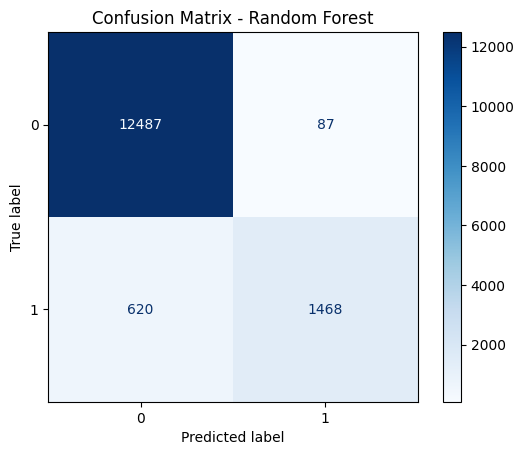

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

best_rf = grid_search_rf.best_estimator_
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest")
plt.show()

### AdaBoost
Finding best learning rate

Better learning rate: 0.1 (Accuracy: 0.9516)


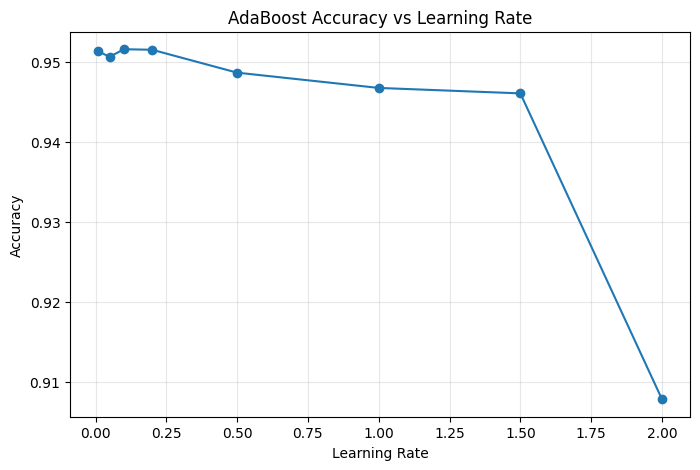

In [ ]:

learning_rates = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 1.5, 2.0]
accuracies = []

X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

for lr in learning_rates:
    ada = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
        n_estimators=200,
        learning_rate=lr,
        random_state=42
    )
    ada.fit(X_train, y_train)
    y_pred = ada.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

best_lr = learning_rates[np.argmax(accuracies)]
best_acc = max(accuracies)
print(f"Better learning rate: {best_lr} (Accuracy: {best_acc:.4f})")

AdaBoost_score = best_acc
plt.figure(figsize=(8,5))
plt.plot(learning_rates, accuracies, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('AdaBoost Accuracy vs Learning Rate')
plt.grid(True, alpha=0.3)
plt.show()


As we can see, AdaBoost performs better with smaller learning rates. Smaller learning rates in AdaBoost improve performance by allowing the model to learn gradually and avoid overfitting, leading to better generalization 

### Statistics
### Plot Roc Curve for best learning rate

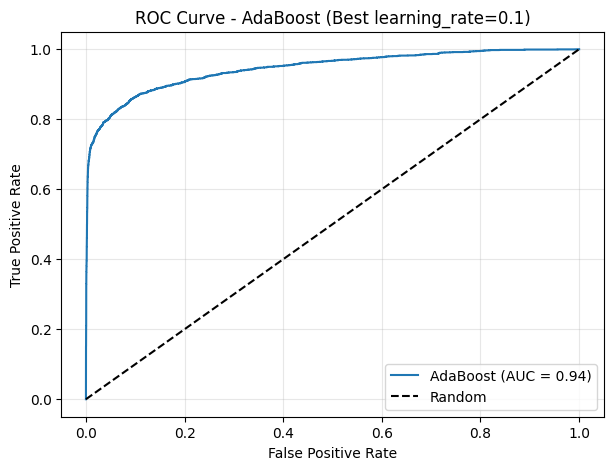

In [ ]:
best_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
    n_estimators=200,
    learning_rate=best_lr,  
    random_state=42
)
best_ada.fit(X_train, y_train)
y_proba = best_ada.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
AdaBoost_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'AdaBoost (AUC = {AdaBoost_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - AdaBoost (Best learning_rate={best_lr})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Precision

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
precision_scores = []

best_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
    n_estimators=200,
    learning_rate=best_lr,
    random_state=42
)

for train_idx, test_idx in cv.split(all_inputs, all_labels):
    X_train, X_test = all_inputs[train_idx], all_inputs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    best_ada.fit(X_train, y_train)
    y_pred = best_ada.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)

print("Precision scores for each fold:", precision_scores)
print(f"Average precision across folds: {np.mean(precision_scores):.4f}")
print(f"Standard deviation of precision: {np.std(precision_scores):.4f}")
AdaBoost_precision = np.mean(precision_scores)

Precision scores for each fold: [0.9089481946624803, 0.9235668789808917, 0.9306184012066365, 0.9433962264150944, 0.9179566563467493, 0.936608557844691, 0.9404580152671755, 0.9231927710843374, 0.934351145038168, 0.9080118694362018]
Average precision across folds: 0.9267
Standard deviation of precision: 0.0118


### Recall

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
recall_scores = []

best_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
    n_estimators=200,
    learning_rate=best_lr,
    random_state=42
)

for train_idx, test_idx in cv.split(all_inputs, all_labels):
    X_train, X_test = all_inputs[train_idx], all_inputs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    best_ada.fit(X_train, y_train)
    y_pred = best_ada.predict(X_test)
    
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)

print("Recall scores for each fold:", recall_scores)
print(f"Average recall across folds: {np.mean(recall_scores):.4f}")
print(f"Standard deviation of recall: {np.std(recall_scores):.4f}")
AdaBoost_recall = np.mean(recall_scores)

Recall scores for each fold: [0.6934131736526946, 0.6946107784431138, 0.7389221556886227, 0.718562874251497, 0.7101796407185629, 0.7077844311377246, 0.7377245508982035, 0.7341317365269461, 0.732934131736527, 0.732934131736527]
Average recall across folds: 0.7201
Standard deviation of recall: 0.0167


### F1

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []

best_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
    n_estimators=200,
    learning_rate=best_lr,
    random_state=42
)

for train_idx, test_idx in cv.split(all_inputs, all_labels):
    X_train, X_test = all_inputs[train_idx], all_inputs[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    best_ada.fit(X_train, y_train)
    y_pred = best_ada.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

print("F1 scores for each fold:", f1_scores)
print(f"Average F1-score across folds: {np.mean(f1_scores):.4f}")
print(f"Standard deviation of F1-score: {np.std(f1_scores):.4f}")
AdaBoost_F1 = np.mean(f1_scores)

F1 scores for each fold: [0.7866847826086957, 0.7928913192071086, 0.8237650200267023, 0.8157715839564922, 0.800810263335584, 0.8062755798090041, 0.8268456375838926, 0.8178785857238159, 0.8214765100671141, 0.8111332007952287]
Average F1-score across folds: 0.8104
Standard deviation of F1-score: 0.0128


### Confusion Matrix

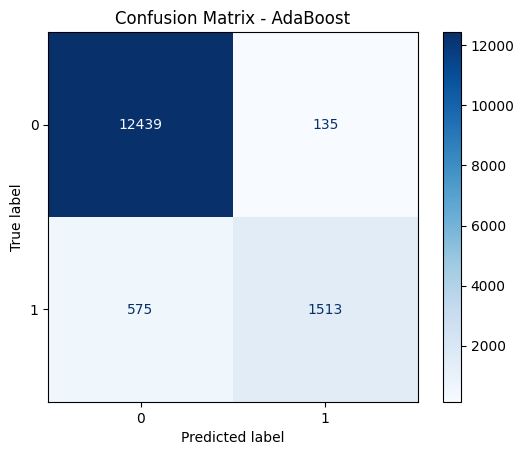

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

best_ada = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=10, max_features=11, random_state=42),
    n_estimators=200,
    learning_rate=best_lr,
    random_state=42
)

best_ada.fit(X_train, y_train)
y_pred = best_ada.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - AdaBoost")
plt.show()

FEATURE SELECTION

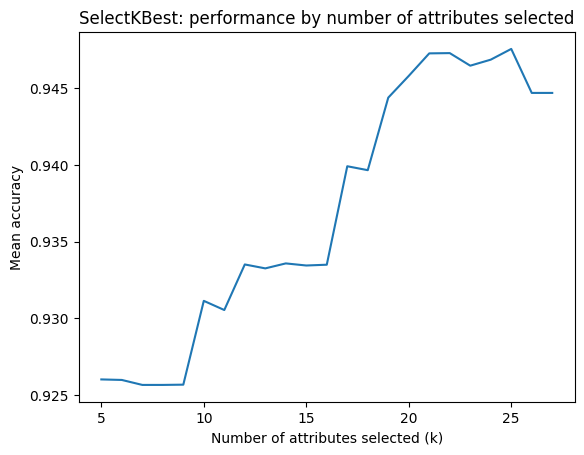

Best k: 25 with mean accuracy: 0.9475
Best attributes selected: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N']


In [42]:
feature_names = list(data.drop(columns='loan_status').columns)

best_clf = DecisionTreeClassifier(
    criterion='gini',
    max_depth=9,
    max_features=11,
    splitter='best',
    random_state=1
)

k_range = range(5, len(feature_names) + 1)
mean_scores = []

for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([
        ('select', selector),
        ('clf', best_clf)
    ])
    scores = cross_val_score(pipeline, all_inputs, all_labels, cv=StratifiedKFold(n_splits=7), scoring='accuracy')
    mean_scores.append(scores.mean())

plt.plot(k_range, mean_scores)
plt.xlabel("Number of attributes selected (k)")
plt.ylabel("Mean accuracy")
plt.title("SelectKBest: performance by number of attributes selected")
plt.show()

best_k = k_range[mean_scores.index(max(mean_scores))]
print(f"Best k: {best_k} with mean accuracy: {max(mean_scores):.4f}")


# Apply SelectKBest with best k
selector = SelectKBest(score_func=f_classif, k=best_k)
selector.fit(all_inputs, all_labels)
selected_mask = selector.get_support()
selected_features = [f for f, s in zip(feature_names, selected_mask) if s]

print("Best attributes selected:", selected_features)

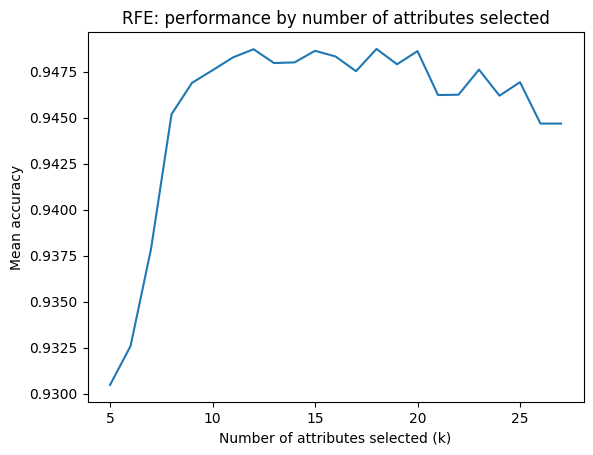

RFE - Best k: 18 with mean accuracy: 0.9487
Selected attributes by RFE: ['id', 'person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_PERSONAL', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D']


In [45]:
rfe_scores = []
k_range = range(5, len(feature_names) + 1)

for k in k_range:
    selector = RFE(estimator=best_clf, n_features_to_select=k)
    pipeline = Pipeline([
        ('select', selector),
        ('clf', best_clf)
    ])
    scores = cross_val_score(pipeline, all_inputs, all_labels, cv=StratifiedKFold(n_splits=7), scoring='accuracy')
    rfe_scores.append(scores.mean())

plt.plot(k_range, rfe_scores)
plt.xlabel("Number of attributes selected (k)")
plt.ylabel("Mean accuracy")
plt.title("RFE: performance by number of attributes selected")
plt.show()

best_k_rfe = k_range[rfe_scores.index(max(rfe_scores))]
print(f"RFE - Best k: {best_k_rfe} with mean accuracy: {max(rfe_scores):.4f}")

rfe_selector = RFE(estimator=best_clf, n_features_to_select=best_k_rfe)
rfe_selector.fit(all_inputs, all_labels)
rfe_selected_features = [f for f, s in zip(feature_names, rfe_selector.support_) if s]
print("Selected attributes by RFE:", rfe_selected_features)


### XGBoost

Finding best parameters while using categorical data 

In [ ]:

data_categorical = pd.read_csv('train.csv')
feature_cols = [col for col in data_categorical.columns if col not in ['loan_status', 'id']]
data_categorical[feature_cols] = data_categorical[feature_cols].astype(str)
data_categorical = pd.get_dummies(data_categorical, columns=feature_cols)
all_inputs_cat = data_categorical.drop(columns=["loan_status", "id"]).values
all_labels_cat = data_categorical["loan_status"].values

param_grid = {
    'n_estimators': [1000],
    'max_depth': [1, 2, 3, 4],
    'learning_rate': [0.05, 0.1, 0.2]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)
grid_search.fit(all_inputs_cat, all_labels_cat)

print("Best XGBoost score (all categorical):", grid_search.best_score_)
print("Best XGBoost params (all categorical):", grid_search.best_params_)
XGBoost_score = grid_search.best_score_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [16:08:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost score (all categorical): 0.9586822656506253
Best XGBoost params (all categorical): {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 1000}


#### Why Categorical Data and XGBoost Work Well Together ?
XGBoost (Extreme Gradient Boosting) is a powerful ensemble algorithm based on gradient-boosted decision trees. While decision trees are naturally well-suited for categorical data, XGBoost enhances this through optimized tree building, regularization, and efficient handling of data.

The best config works well because it balances model complexity and generalization. With a low max depth, each tree remains simple, reducing the risk of overfitting by avoiding overly specific splits. At the same time, using a high number of estimators allows the model to learn gradually through many small, incremental improvements. This slow, controlled learning process enables XGBoost to capture complex patterns in the data while maintaining robustness and stability, often leading to better performance on unseen data.

### Statistics
### Plot Roc Curve for best parameters

c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\xgboost\training.py:183: UserWarning: [14:53:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


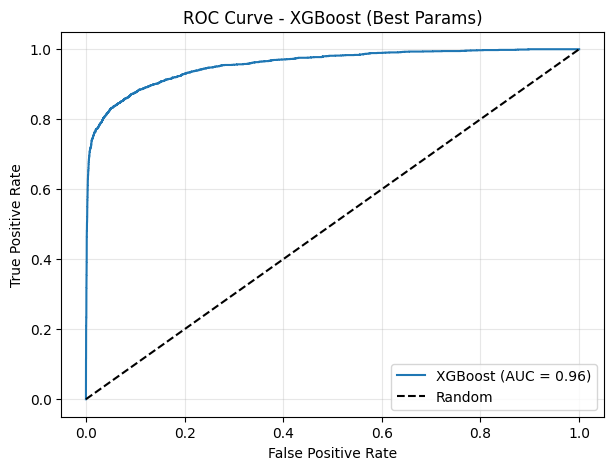

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)
y_proba = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
XGBoost_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {XGBoost_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ----------------------------------------------------------------------
#### k-Nearest Neighbors (k-NN)

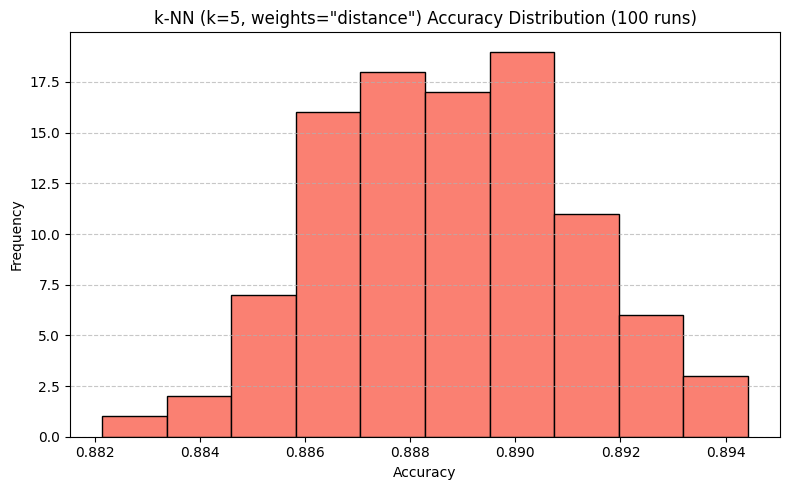

Average Accuracy over 100 runs: 0.8887


In [78]:
k = 5
weights = 'distance'

model_accuracies = []

for repetition in range(100):
    (training_inputs,
     testing_inputs,
     training_classes,
     testing_classes) = train_test_split(all_inputs, all_labels, test_size=0.25)
    
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_classifier.fit(training_inputs, training_classes)
    predicted_classes = knn_classifier.predict(testing_inputs)

    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

plt.figure(figsize=(8, 5))
plt.hist(model_accuracies, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'k-NN (k={k}, weights="{weights}") Accuracy Distribution (100 runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Accuracy over 100 runs: {sum(model_accuracies) / len(model_accuracies):.4f}')


Normalized the input data and applied stratified sampling

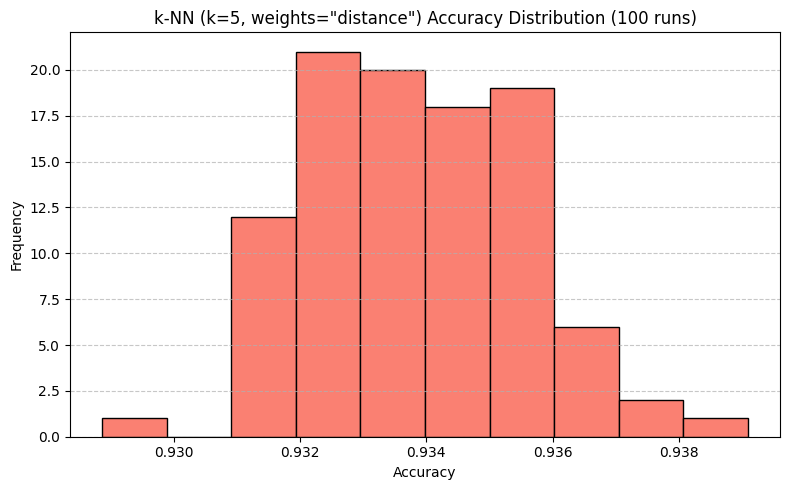

Average Accuracy over 100 runs (updated): 0.9338


In [ ]:
k = 5
weights = 'distance'

model_accuracies = []

for repetition in range(100):
    training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
        all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
    )

    # Normalize the data -> important for models with distance
    scaler = StandardScaler()
    training_inputs_scaled = scaler.fit_transform(training_inputs)
    testing_inputs_scaled = scaler.transform(testing_inputs)

    # Model k-NN Neighbor
    knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
    knn_classifier.fit(training_inputs_scaled, training_classes)
    predicted_classes = knn_classifier.predict(testing_inputs_scaled)

    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

# Results
plt.figure(figsize=(8, 5))
plt.hist(model_accuracies, bins=10, color='salmon', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'k-NN (k={k}, weights="{weights}") Accuracy Distribution (100 runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Accuracy over 100 runs (updated): {sum(model_accuracies) / len(model_accuracies):.4f}')


Trying to find the best k value 

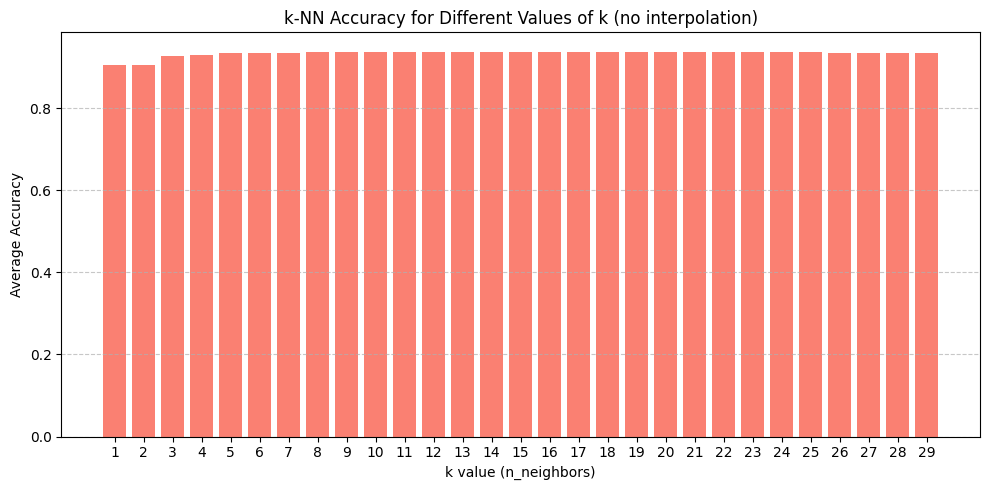

In [ ]:
accuracies_by_k = {}

for k in range(1, 30):
    model_accuracies = []
    
    for _ in range(2):
        training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
            all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
        )
        
        scaler = StandardScaler()
        training_inputs_scaled = scaler.fit_transform(training_inputs)
        testing_inputs_scaled = scaler.transform(testing_inputs)

        knn_classifier = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn_classifier.fit(training_inputs_scaled, training_classes)
        predicted_classes = knn_classifier.predict(testing_inputs_scaled)
        
        model_accuracies.append(accuracy_score(testing_classes, predicted_classes))
    
    # Average of accuracies for the current k
    accuracies_by_k[k] = sum(model_accuracies) / len(model_accuracies)

# Results
plt.figure(figsize=(10, 5))
plt.bar(accuracies_by_k.keys(), accuracies_by_k.values(), color='salmon')
plt.xlabel('k value (n_neighbors)')
plt.ylabel('Average Accuracy')
plt.title('k-NN Accuracy for Different Values of k (no interpolation)')
plt.xticks(list(accuracies_by_k.keys()))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Find best performing parameters

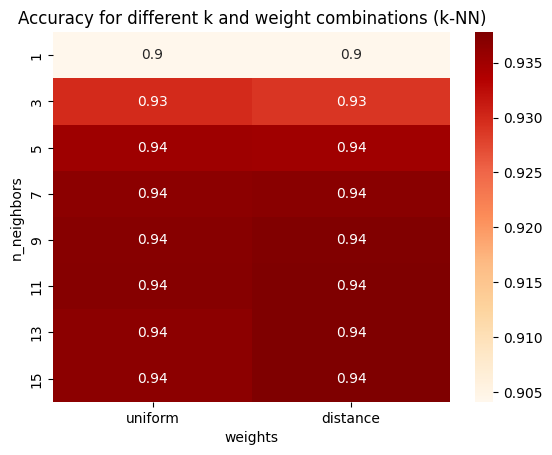

Best score: 0.9378
Best parameters: {'n_neighbors': 11, 'weights': 'distance'}


In [ ]:
# Sets a KNN classifier with stratified cross-validation and a parameter search for optimal values
knn_classifier = KNeighborsClassifier()
parameter_grid = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance']
}
cross_validation = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

# Grid Search
grid_search = GridSearchCV(
    estimator=knn_classifier,
    param_grid=parameter_grid,
    cv=cross_validation,
    scoring='accuracy'
)

# Adjusting model
grid_search.fit(all_inputs_scaled, all_labels)

scores = grid_search.cv_results_['mean_test_score']
grid_visualization = np.array(scores).reshape(len(parameter_grid['n_neighbors']), len(parameter_grid['weights']))

# Results
sns.heatmap(grid_visualization, cmap='OrRd', annot=True, xticklabels=parameter_grid['weights'], yticklabels=parameter_grid['n_neighbors'])
plt.xlabel('weights')
plt.ylabel('n_neighbors')
plt.title('Accuracy for different k and weight combinations (k-NN)')
plt.show()

print('Best score: {:.4f}'.format(grid_search.best_score_))
print('Best parameters:', grid_search.best_params_)
Knn_score = grid_search.best_score_


### Statistics
### Plot Roc Curve for best parameters

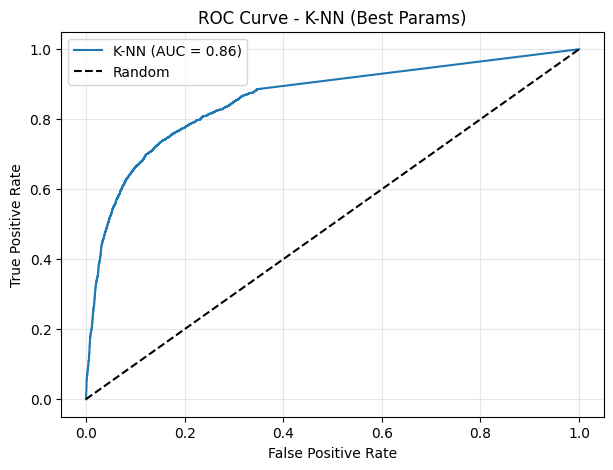

In [ ]:
training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

best_tree = grid_search.best_estimator_
best_tree.fit(training_inputs, training_classes)

y_proba = best_tree.predict_proba(testing_inputs)[:, 1]

fpr, tpr, thresholds = roc_curve(testing_classes, y_proba)
Knn_auc = roc_auc_score(testing_classes, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'K-NN (AUC = {Knn_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - K-NN (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Learning curve (training and validation accuracy)

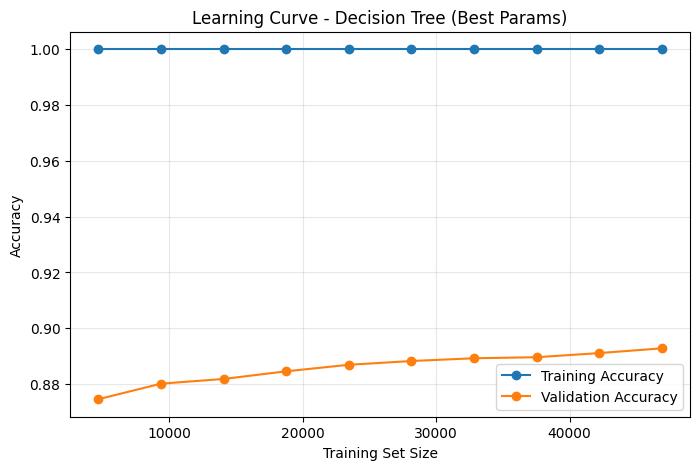

In [ ]:
best_tree = grid_search.best_estimator_

train_sizes, train_scores, val_scores = learning_curve(
    best_tree,
    all_inputs, all_labels,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)

plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - K-NN (Best Params)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Precision

In [ ]:
knn_best = grid_search.best_estimator_

precision_scores = cross_val_score(
    knn_best,
    all_inputs_scaled,
    all_labels,
    cv=stratified_kfold,
    scoring='precision'
)

print("Precision scores for each fold (best params):", precision_scores)
print("Average precision across 10 folds (best params): {:.4f}".format(precision_scores.mean()))
Knn_precision = precision_scores.mean()

Precision scores for each fold (best params): [0.89438944 0.90212072 0.88474026 0.89368771 0.88013136 0.90048154
 0.87581699 0.88513514 0.88812392 0.87438017]
Average precision across 10 folds (best params): 0.8879


### Recall

In [ ]:
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance')

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

recall_scores = cross_val_score(
    knn_classifier,
    all_inputs_scaled,
    all_labels,
    cv=stratified_kfold,
    scoring='recall'
)

print("Recall scores for each fold (k-NN):", recall_scores)
print("Average recall across 10 folds (k-NN): {:.4f}".format(recall_scores.mean()))
Knn_recall = recall_scores.mean()

Recall scores for each fold (k-NN): [0.66107784 0.67185629 0.66347305 0.65389222 0.6491018  0.67185629
 0.6491018  0.63592814 0.61916168 0.62634731]
Average recall across 10 folds (k-NN): 0.6502


### F1 

In [ ]:

knn_best = grid_search.best_estimator_

stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

f1_scores = cross_val_score(
    knn_best,
    all_inputs_scaled,
    all_labels,
    cv=stratified_kfold,
    scoring='f1'
)

print("F1 scores for each fold (best params):", f1_scores)
print("Average F1-score across 10 folds (best params): {:.4f}".format(f1_scores.mean()))
Knn_F1 = f1_scores.mean()

F1 scores for each fold (best params): [0.75225538 0.76381215 0.75120606 0.74878219 0.74238227 0.76954733
 0.74084312 0.73440785 0.72881356 0.73472222]
Average F1-score across 10 folds (best params): 0.7467


### Confusion Matrix

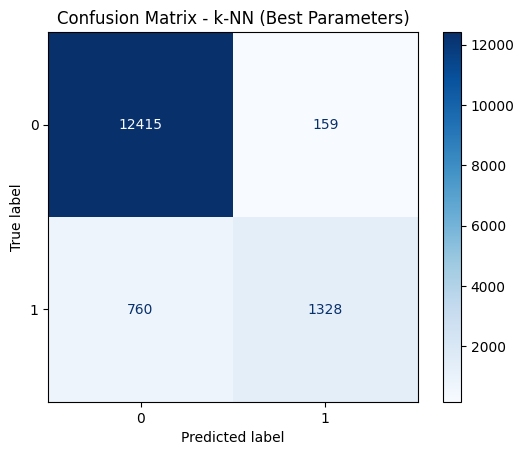

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=1
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_best = grid_search.best_estimator_
knn_best.fit(X_train_scaled, y_train)

y_pred = knn_best.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - k-NN (Best Parameters)")
plt.show()

FEATURE SELECTION

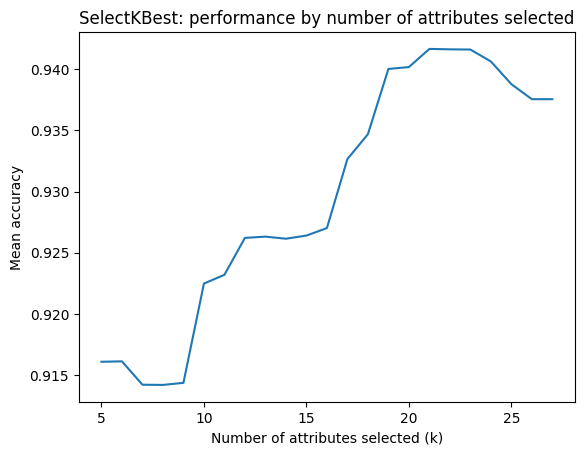

SelectKBest - Best k: 21 with mean accuracy: 0.9417
Selected attributes by SelectKBest: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'cb_person_cred_hist_length', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'loan_grade_A', 'loan_grade_C', 'loan_grade_D', 'loan_grade_E', 'loan_grade_F', 'loan_grade_G', 'cb_person_default_on_file_N']


In [ ]:
best_knn = KNeighborsClassifier(n_neighbors=11, weights='distance')

k_range = range(5, len(feature_names) + 1)
kbest_scores = []

for k in k_range:
    selector = SelectKBest(score_func=f_classif, k=k)
    pipeline = Pipeline([
        ('select', selector),
        ('clf', best_knn)
    ])
    scores = cross_val_score(pipeline, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=7), scoring='accuracy')
    kbest_scores.append(scores.mean())

plt.plot(k_range, kbest_scores)
plt.xlabel("Number of attributes selected (k)")
plt.ylabel("Mean accuracy")
plt.title("SelectKBest: performance by number of attributes selected")
plt.show()

best_k_kbest = k_range[kbest_scores.index(max(kbest_scores))]
print(f"SelectKBest - Best k: {best_k_kbest} with mean accuracy: {max(kbest_scores):.4f}")

selector = SelectKBest(score_func=f_classif, k=best_k_kbest)
selector.fit(all_inputs_scaled, all_labels)
selected_features_kbest = [f for f, s in zip(feature_names, selector.get_support()) if s]
print("Selected attributes by SelectKBest:", selected_features_kbest)

# ----------------------------------------------------------------------
#### Neural Networks (NN)

In [ ]:
class NeuralNetwork:
    def __init__(self, input_shape):
        self.model = self.build_model(input_shape)

    def build_model(self, input_shape):
        model = keras.Sequential()
        model.add(layers.Dense(64, activation='relu', input_shape=(input_shape,)))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(1, activation='sigmoid'))  
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    def train(self, X_train, y_train, epochs=50, batch_size=16):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

    def predict(self, X):
        return (self.model.predict(X) > 0.5).astype("int32")

    def evaluate(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test, verbose=0)
        return accuracy

In [ ]:
# Neural Network Training and Evaluation
data = pd.read_csv('train.csv')
data = pd.get_dummies(data, columns=["person_home_ownership", "loan_intent", "loan_grade", "cb_person_default_on_file"])
X = data.drop(columns=['loan_status', 'id']).values
y = data['loan_status'].values

# Spliting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

# Normalizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Initializing and training the neural network
nn = NeuralNetwork(input_shape=X_train.shape[1])
nn.train(X_train, y_train, epochs=10, batch_size=16, verbose=0)

# Evaluating the model
accuracy = nn.evaluate(X_test, y_test)
print(f'Neural Network Accuracy: {accuracy:.4f}')

c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.8928 - loss: 0.2665
Epoch 2/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9393 - loss: 0.1924
Epoch 3/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9420 - loss: 0.1862
Epoch 4/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9432 - loss: 0.1838
Epoch 5/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9424 - loss: 0.1862
Epoch 6/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9460 - loss: 0.1788
Epoch 7/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9448 - loss: 0.1800
Epoch 8/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9473 - loss: 0.1730
Epoch 9/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9465 - loss: 0.1730
Epoch 10/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.9441 - loss: 0.1787
Neural Network Accuracy: 0.9449


Accuracy Distribution

Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 615us/step - accuracy: 0.9192 - loss: 0.2406
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 598us/step - accuracy: 0.9390 - loss: 0.1938
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 611us/step - accuracy: 0.9409 - loss: 0.1889
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 668us/step - accuracy: 0.9407 - loss: 0.1893
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 663us/step - accuracy: 0.9453 - loss: 0.1784
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 694us/step - accuracy: 0.8985 - loss: 0.2676
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step - accuracy: 0.9429 - loss: 0.1836
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 705us/step - accuracy: 0.9414 - loss: 0.1867
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 716us/step - accuracy: 0.9457 - loss: 0.1770
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 717us/step - accuracy: 0.9438 - loss: 0.1813
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 756us/step - accuracy: 0.9132 - loss: 0.2470
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 720us/step - accuracy: 0.9376 - loss: 0.1938
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 729us/step - accuracy: 0.9404 - loss: 0.1878
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 716us/step - accuracy: 0.9427 - loss: 0.1807
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 744us/step - accuracy: 0.9410 - loss: 0.1846
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 746us/step - accuracy: 0.9129 - loss: 0.2457
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 742us/step - accuracy: 0.9390 - loss: 0.1963
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 728us/step - accuracy: 0.9421 - loss: 0.1864
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - accuracy: 0.9426 - loss: 0.1820
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 722us/step - accuracy: 0.9431 - loss: 0.1823
Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 723us/step - accuracy: 0.9037 - loss: 0.2618
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 726us/step - accuracy: 0.9410 - loss: 0.1923
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 719us/step - accuracy: 0.9404 - loss: 0.1894
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 721us/step - accuracy: 0.9422 - loss: 0.1847
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 718us/step - accuracy: 0.9415 - loss: 0.1867


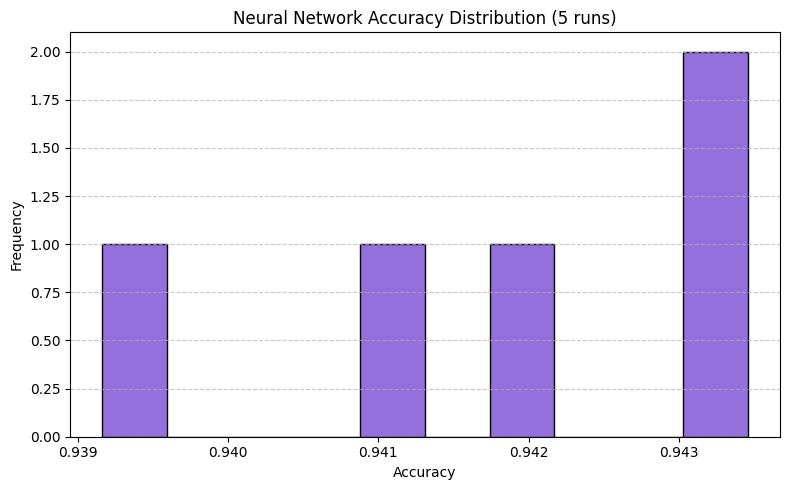

Average Neural Network Accuracy over 5 runs: 0.9417


In [ ]:
# Neural Network: Accuracy Distribution over Multiple Runs
nn_accuracies = []
num_runs = 5 

for repetition in range(num_runs):
    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, stratify=y, random_state=repetition
    )
    # Normalizing the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # Training NN
    nn = NeuralNetwork(input_shape=X_train.shape[1])
    nn.train(X_train_scaled, y_train, epochs=5, batch_size=16, verbose=0) 
    # Evaluating NN
    acc = nn.evaluate(X_test_scaled, y_test)
    nn_accuracies.append(acc)

# Plot accuracy distribution
plt.figure(figsize=(8, 5))
plt.hist(nn_accuracies, bins=10, color='mediumpurple', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'Neural Network Accuracy Distribution ({num_runs} runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Neural Network Accuracy over {num_runs} runs: {np.mean(nn_accuracies):.4f}')

NN_score = np.max(nn_accuracies)

Standard Deviation


In [ ]:
std_dev = np.std(nn_accuracies)
print(f'Standard Deviation: {std_dev:.4f}')

Standard Deviation: 0.0016


Minimum/ Maximum Accuracy

In [7]:
min_acc = np.min(nn_accuracies)
max_acc = np.max(nn_accuracies)
print(f'Minimum Accuracy: {min_acc:.4f}')
print(f'Maximum Accuracy: {max_acc:.4f}')


Minimum Accuracy: 0.9392
Maximum Accuracy: 0.9435


Confidence Interval

In [ ]:

confidence_interval = stats.t.interval(0.95, len(nn_accuracies)-1, loc=np.mean(nn_accuracies), scale=stats.sem(nn_accuracies))
lower_bound, upper_bound = confidence_interval
print(f'95% Confidence Interval: ({lower_bound:.4f}, {upper_bound:.4f})')



95% Confidence Interval: (0.9396, 0.9439)


Boxplot of Accuracy Distribution

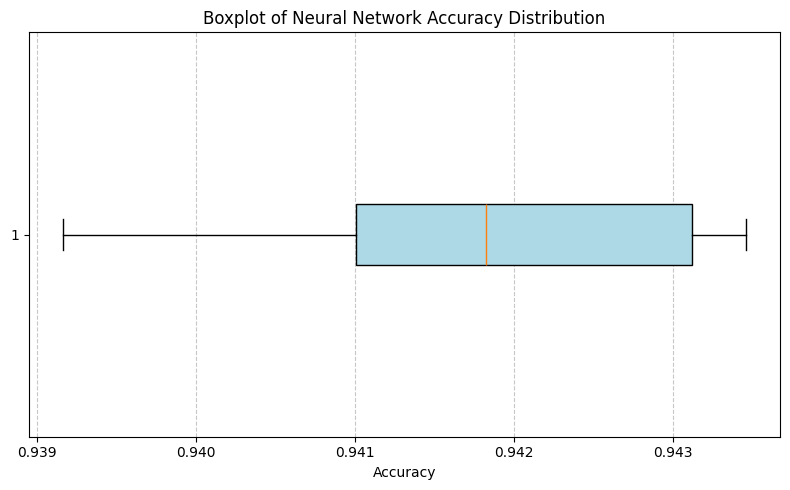

In [9]:
plt.figure(figsize=(8, 5))
plt.boxplot(nn_accuracies, vert=False, patch_artist=True, boxprops=dict(facecolor='lightblue', color='black'))
plt.title('Boxplot of Neural Network Accuracy Distribution')
plt.xlabel('Accuracy')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


C:\Users\costi\AppData\Local\Temp\ipykernel_10968\1992047977.py:4: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(nn_accuracies, shade=True, color='mediumpurple')


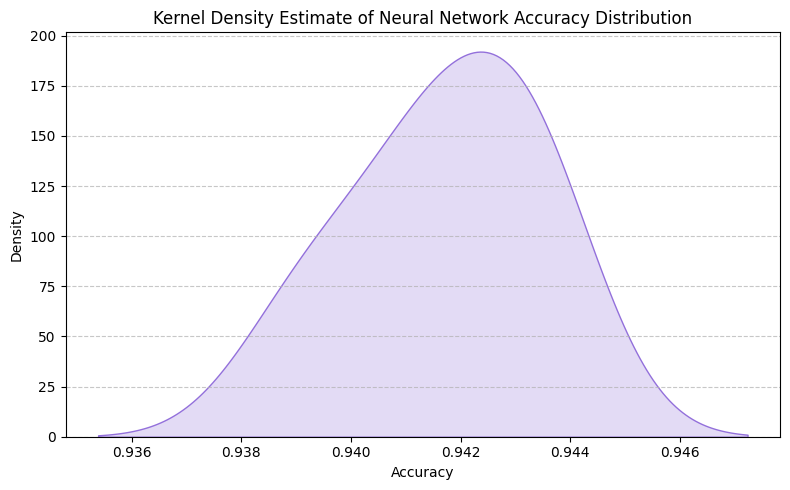

In [ ]:

plt.figure(figsize=(8, 5))
sns.kdeplot(nn_accuracies, shade=True, color='mediumpurple')
plt.title('Kernel Density Estimate of Neural Network Accuracy Distribution')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Statistics
### Plot Roc Curve for best parameters

Epoch 1/5


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 650us/step - accuracy: 0.9040 - loss: 0.2603
Epoch 2/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 606us/step - accuracy: 0.9402 - loss: 0.1901
Epoch 3/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 604us/step - accuracy: 0.9415 - loss: 0.1858
Epoch 4/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 696us/step - accuracy: 0.9429 - loss: 0.1807
Epoch 5/5
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 2s 759us/step - accuracy: 0.9430 - loss: 0.1838
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 485us/step


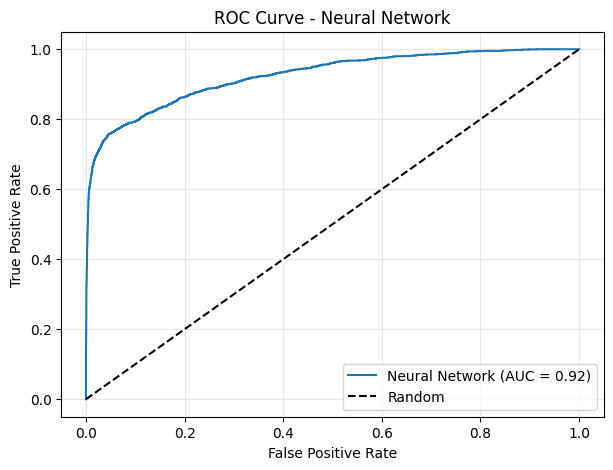

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn = NeuralNetwork(input_shape=X_train.shape[1])
nn.train(X_train_scaled, y_train, epochs=5, batch_size=16, verbose=0)

y_proba = nn.model.predict(X_test_scaled).ravel()

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
NN_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f'Neural Network (AUC = {NN_auc:.4f})')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Neural Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Learning curve (training and validation accuracy)

Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 646us/step - accuracy: 0.8385 - loss: 0.3856
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - accuracy: 0.9201 - loss: 0.2268
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - accuracy: 0.9305 - loss: 0.2090
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 625us/step - accuracy: 0.9335 - loss: 0.2038
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.9389 - loss: 0.1878
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 663us/step - accuracy: 0.9339 - loss: 0.1951
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 656us/step - accuracy: 0.9429 - loss: 0.1749
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9453 - loss: 0.1741
Epoch 9/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 710us/step - accuracy: 0.9365 - loss: 0.1874
Epoch 10/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - accuracy: 0.9422 - loss: 0.1777
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 645us/step - accuracy: 0.8732 - loss: 0.3464
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 636us/step - accuracy: 0.9236 - loss: 0.2168
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 630us/step - accuracy: 0.9310 - loss: 0.1985
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 650us/step - accuracy: 0.9296 - loss: 0.2086
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 773us/step - accuracy: 0.9402 - loss: 0.1805
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.9352 - loss: 0.1939
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 702us/step - accuracy: 0.9358 - loss: 0.1885
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 787us/step - accuracy: 0.9423 - loss: 0.1758
Epoch 9/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 771us/step - accuracy: 0.9386 - loss: 0.1830
Epoch 10/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - accuracy: 0.9406 - loss: 0.1725
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 814us/step - accuracy: 0.8719 - loss: 0.3516
Epoch 2/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 809us/step - accuracy: 0.9284 - loss: 0.2204
Epoch 3/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9371 - loss: 0.1942
Epoch 4/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - accuracy: 0.9369 - loss: 0.1941
Epoch 5/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 768us/step - accuracy: 0.9395 - loss: 0.1917
Epoch 6/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.9408 - loss: 0.1808
Epoch 7/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 814us/step - accuracy: 0.9428 - loss: 0.1681
Epoch 8/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 742us/step - accuracy: 0.9451 - loss: 0.1676
Epoch 9/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - accuracy: 0.9390 - loss: 0.1761
Epoch 10/10
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 755us/step - accuracy: 0.9450 - loss: 0.1713
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step - accuracy: 0.8917 - loss: 0.2994
Epoch 2/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9318 - loss: 0.2014
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 871us/step - accuracy: 0.9373 - loss: 0.1937
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 674us/step - accuracy: 0.9389 - loss: 0.1940
Epoch 5/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9386 - loss: 0.1886
Epoch 6/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9414 - loss: 0.1777
Epoch 7/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9407 - loss: 0.1848
Epoch 8/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step - accuracy: 0.9422 - loss: 0.1806
Epoch 9/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9438 - loss: 0.1758
Epoch 10/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.9456 - loss: 0.1683
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - accuracy: 0.8810 - loss: 0.3149
Epoch 2/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step - accuracy: 0.9319 - loss: 0.2120
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 790us/step - accuracy: 0.9322 - loss: 0.2079
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 962us/step - accuracy: 0.9391 - loss: 0.1934
Epoch 5/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9393 - loss: 0.1874
Epoch 6/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9384 - loss: 0.1904
Epoch 7/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.9394 - loss: 0.1860
Epoch 8/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.9429 - loss: 0.1848
Epoch 9/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.9377 - loss: 0.1907
Epoch 10/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step - accuracy: 0.9412 - loss: 0.1810
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 717us/step - accuracy: 0.8922 - loss: 0.2910
Epoch 2/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.9330 - loss: 0.2076
Epoch 3/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 778us/step - accuracy: 0.9363 - loss: 0.1964
Epoch 4/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 773us/step - accuracy: 0.9374 - loss: 0.1949
Epoch 5/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - accuracy: 0.9386 - loss: 0.1890
Epoch 6/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 774us/step - accuracy: 0.9408 - loss: 0.1800
Epoch 7/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step - accuracy: 0.9403 - loss: 0.1824
Epoch 8/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 832us/step - accuracy: 0.9431 - loss: 0.1728
Epoch 9/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 810us/step - accuracy: 0.9447 - loss: 0.1751
Epoch 10/10
786/786 ━━━━━━━━━━━━━━━━━━━━ 1s 809us/step - accuracy: 0.9470 - loss: 0.1668
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 703us/step - accuracy: 0.8966 - loss: 0.2892
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 732us/step - accuracy: 0.9317 - loss: 0.2057
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step - accuracy: 0.9361 - loss: 0.1922
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 711us/step - accuracy: 0.9386 - loss: 0.1930
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9400 - loss: 0.1867
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9393 - loss: 0.1834
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 721us/step - accuracy: 0.9386 - loss: 0.1842
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 715us/step - accuracy: 0.9407 - loss: 0.1830
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9396 - loss: 0.1816
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 752us/step - accuracy: 0.9424 - loss: 0.1784
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 682us/step - accuracy: 0.8760 - loss: 0.3060
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9340 - loss: 0.2022
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9385 - loss: 0.1967
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9415 - loss: 0.1851
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.9392 - loss: 0.1894
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9405 - loss: 0.1834
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9425 - loss: 0.1828
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 687us/step - accuracy: 0.9431 - loss: 0.1777
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9455 - loss: 0.1743
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.9454 - loss: 0.1707
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.8881 - loss: 0.2969
Epoch 2/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9297 - loss: 0.2093
Epoch 3/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 664us/step - accuracy: 0.9373 - loss: 0.1913
Epoch 4/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.9420 - loss: 0.1831
Epoch 5/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9391 - loss: 0.1906
Epoch 6/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9419 - loss: 0.1807
Epoch 7/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 683us/step - accuracy: 0.9429 - loss: 0.1770
Epoch 8/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9450 - loss: 0.1754
Epoch 9/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9430 - loss: 0.1778
Epoch 10/10
1205/1205 ━━━━━━━━━━━━━━━━━━━━ 1s 681us/step - accuracy: 0.9470 - loss: 0.1696
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 679us/step - accuracy: 0.8919 - loss: 0.2771
Epoch 2/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.9368 - loss: 0.1958
Epoch 3/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 671us/step - accuracy: 0.9397 - loss: 0.1906
Epoch 4/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 668us/step - accuracy: 0.9424 - loss: 0.1823
Epoch 5/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9414 - loss: 0.1834
Epoch 6/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 697us/step - accuracy: 0.9434 - loss: 0.1805
Epoch 7/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9446 - loss: 0.1761
Epoch 8/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 678us/step - accuracy: 0.9432 - loss: 0.1823
Epoch 9/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.9440 - loss: 0.1777
Epoch 10/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 677us/step - accuracy: 0.9477 - loss: 0.1666
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.8876 - loss: 0.2831
Epoch 2/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 666us/step - accuracy: 0.9399 - loss: 0.1927
Epoch 3/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9382 - loss: 0.1931
Epoch 4/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 663us/step - accuracy: 0.9405 - loss: 0.1873
Epoch 5/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 673us/step - accuracy: 0.9416 - loss: 0.1859
Epoch 6/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 662us/step - accuracy: 0.9396 - loss: 0.1845
Epoch 7/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step - accuracy: 0.9455 - loss: 0.1747
Epoch 8/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 695us/step - accuracy: 0.9456 - loss: 0.1760
Epoch 9/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 688us/step - accuracy: 0.9442 - loss: 0.1776
Epoch 10/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 675us/step - accuracy: 0.9470 - loss: 0.1751
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1624/1624 ━━━━━━━━━━━━━━━━━━━━ 2s 693us/step - accuracy: 0.9021 - loss: 0.2731
Epoch 2/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 691us/step - accuracy: 0.9362 - loss: 0.1937
Epoch 3/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step - accuracy: 0.9362 - loss: 0.1920
Epoch 4/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 744us/step - accuracy: 0.9418 - loss: 0.1830
Epoch 5/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 722us/step - accuracy: 0.9423 - loss: 0.1823
Epoch 6/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 728us/step - accuracy: 0.9434 - loss: 0.1821
Epoch 7/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 658us/step - accuracy: 0.9443 - loss: 0.1802
Epoch 8/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 632us/step - accuracy: 0.9445 - loss: 0.1780
Epoch 9/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 636us/step - accuracy: 0.9445 - loss: 0.1754
Epoch 10/10
1624/1624 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.9454 - loss: 0.1756
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2043/2043 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.9068 - loss: 0.2553
Epoch 2/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step - accuracy: 0.9367 - loss: 0.1970
Epoch 3/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 643us/step - accuracy: 0.9403 - loss: 0.1848
Epoch 4/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 644us/step - accuracy: 0.9427 - loss: 0.1801
Epoch 5/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 627us/step - accuracy: 0.9429 - loss: 0.1822
Epoch 6/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.9438 - loss: 0.1825
Epoch 7/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 642us/step - accuracy: 0.9433 - loss: 0.1791
Epoch 8/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.9446 - loss: 0.1806
Epoch 9/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 670us/step - accuracy: 0.9468 - loss: 0.1730
Epoch 10/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9442 - loss: 0.1775
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2043/2043 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step - accuracy: 0.8866 - loss: 0.2800
Epoch 2/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 639us/step - accuracy: 0.9365 - loss: 0.1949
Epoch 3/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 625us/step - accuracy: 0.9399 - loss: 0.1888
Epoch 4/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - accuracy: 0.9420 - loss: 0.1881
Epoch 5/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 633us/step - accuracy: 0.9406 - loss: 0.1847
Epoch 6/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.9445 - loss: 0.1776
Epoch 7/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 654us/step - accuracy: 0.9437 - loss: 0.1791
Epoch 8/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.9451 - loss: 0.1778
Epoch 9/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.9461 - loss: 0.1701
Epoch 10/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 647us/step - accuracy: 0.9462 - loss: 0.1726
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2043/2043 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.9135 - loss: 0.2464
Epoch 2/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 660us/step - accuracy: 0.9360 - loss: 0.1931
Epoch 3/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 638us/step - accuracy: 0.9390 - loss: 0.1894
Epoch 4/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.9417 - loss: 0.1855
Epoch 5/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 676us/step - accuracy: 0.9443 - loss: 0.1792
Epoch 6/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9432 - loss: 0.1808
Epoch 7/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 685us/step - accuracy: 0.9458 - loss: 0.1781
Epoch 8/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 641us/step - accuracy: 0.9444 - loss: 0.1791
Epoch 9/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.9471 - loss: 0.1723
Epoch 10/10
2043/2043 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step - accuracy: 0.9470 - loss: 0.1728
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step - accuracy: 0.9010 - loss: 0.2622
Epoch 2/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - accuracy: 0.9374 - loss: 0.1942
Epoch 3/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 674us/step - accuracy: 0.9397 - loss: 0.1893
Epoch 4/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 692us/step - accuracy: 0.9441 - loss: 0.1816
Epoch 5/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 675us/step - accuracy: 0.9449 - loss: 0.1788
Epoch 6/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 678us/step - accuracy: 0.9443 - loss: 0.1793
Epoch 7/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 646us/step - accuracy: 0.9464 - loss: 0.1767
Epoch 8/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step - accuracy: 0.9490 - loss: 0.1714
Epoch 9/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 639us/step - accuracy: 0.9477 - loss: 0.1744
Epoch 10/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.9468 - loss: 0.1715
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step - accuracy: 0.9128 - loss: 0.2538
Epoch 2/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 622us/step - accuracy: 0.9360 - loss: 0.1931
Epoch 3/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 635us/step - accuracy: 0.9407 - loss: 0.1859
Epoch 4/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - accuracy: 0.9442 - loss: 0.1778
Epoch 5/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step - accuracy: 0.9411 - loss: 0.1824
Epoch 6/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - accuracy: 0.9455 - loss: 0.1751
Epoch 7/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step - accuracy: 0.9432 - loss: 0.1842
Epoch 8/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.9450 - loss: 0.1766
Epoch 9/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step - accuracy: 0.9465 - loss: 0.1749
Epoch 10/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 680us/step - accuracy: 0.9439 - loss: 0.1756
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 790us/step - accuracy: 0.8918 - loss: 0.2739
Epoch 2/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 792us/step - accuracy: 0.9362 - loss: 0.1981
Epoch 3/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 713us/step - accuracy: 0.9411 - loss: 0.1887
Epoch 4/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 635us/step - accuracy: 0.9433 - loss: 0.1810
Epoch 5/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step - accuracy: 0.9455 - loss: 0.1774
Epoch 6/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.9472 - loss: 0.1718
Epoch 7/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 645us/step - accuracy: 0.9473 - loss: 0.1712
Epoch 8/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.9456 - loss: 0.1747
Epoch 9/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step - accuracy: 0.9448 - loss: 0.1758
Epoch 10/10
2461/2461 ━━━━━━━━━━━━━━━━━━━━ 2s 682us/step - accuracy: 0.9470 - loss: 0.1724
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 618us/step - accuracy: 0.9104 - loss: 0.2540
Epoch 2/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.9397 - loss: 0.1892
Epoch 3/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.9416 - loss: 0.1869
Epoch 4/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 637us/step - accuracy: 0.9427 - loss: 0.1841
Epoch 5/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 639us/step - accuracy: 0.9447 - loss: 0.1768
Epoch 6/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step - accuracy: 0.9464 - loss: 0.1753
Epoch 7/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step - accuracy: 0.9466 - loss: 0.1741
Epoch 8/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.9477 - loss: 0.1723
Epoch 9/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9476 - loss: 0.1728
Epoch 10/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - accuracy: 0.9462 - loss: 0.1740
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 619us/step - accuracy: 0.9107 - loss: 0.2448
Epoch 2/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9401 - loss: 0.1919
Epoch 3/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9410 - loss: 0.1892
Epoch 4/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step - accuracy: 0.9435 - loss: 0.1826
Epoch 5/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step - accuracy: 0.9453 - loss: 0.1791
Epoch 6/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 639us/step - accuracy: 0.9452 - loss: 0.1800
Epoch 7/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9459 - loss: 0.1749
Epoch 8/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 642us/step - accuracy: 0.9468 - loss: 0.1743
Epoch 9/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 614us/step - accuracy: 0.9475 - loss: 0.1710
Epoch 10/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 616us/step - accuracy: 0.9476 - loss: 0.1722
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.8884 - loss: 0.2713
Epoch 2/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 641us/step - accuracy: 0.9383 - loss: 0.1927
Epoch 3/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step - accuracy: 0.9403 - loss: 0.1869
Epoch 4/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 617us/step - accuracy: 0.9427 - loss: 0.1851
Epoch 5/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step - accuracy: 0.9425 - loss: 0.1833
Epoch 6/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step - accuracy: 0.9435 - loss: 0.1806
Epoch 7/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 629us/step - accuracy: 0.9457 - loss: 0.1780
Epoch 8/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 640us/step - accuracy: 0.9459 - loss: 0.1747
Epoch 9/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 620us/step - accuracy: 0.9450 - loss: 0.1770
Epoch 10/10
2880/2880 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9470 - loss: 0.1728
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 612us/step - accuracy: 0.9005 - loss: 0.2569
Epoch 2/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - accuracy: 0.9387 - loss: 0.1901
Epoch 3/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step - accuracy: 0.9408 - loss: 0.1871
Epoch 4/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 619us/step - accuracy: 0.9421 - loss: 0.1854
Epoch 5/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 618us/step - accuracy: 0.9434 - loss: 0.1833
Epoch 6/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 613us/step - accuracy: 0.9450 - loss: 0.1800
Epoch 7/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 643us/step - accuracy: 0.9462 - loss: 0.1743
Epoch 8/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 628us/step - accuracy: 0.9472 - loss: 0.1709
Epoch 9/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 623us/step - accuracy: 0.9465 - loss: 0.1732
Epoch 10/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step - accuracy: 0.9446 - loss: 0.1795
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9118 - loss: 0.2483
Epoch 2/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.9387 - loss: 0.1951
Epoch 3/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 636us/step - accuracy: 0.9426 - loss: 0.1853
Epoch 4/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 634us/step - accuracy: 0.9428 - loss: 0.1859
Epoch 5/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 626us/step - accuracy: 0.9431 - loss: 0.1861
Epoch 6/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 631us/step - accuracy: 0.9458 - loss: 0.1781
Epoch 7/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step - accuracy: 0.9449 - loss: 0.1808
Epoch 8/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 630us/step - accuracy: 0.9476 - loss: 0.1732
Epoch 9/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 626us/step - accuracy: 0.9471 - loss: 0.1743
Epoch 10/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 623us/step - accuracy: 0.9473 - loss: 0.1737
Epoch 1/10


c:\Users\costi\Desktop\Projects\IA_project2\.venv\lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 610us/step - accuracy: 0.9171 - loss: 0.2406
Epoch 2/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 649us/step - accuracy: 0.9377 - loss: 0.1930
Epoch 3/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 627us/step - accuracy: 0.9417 - loss: 0.1860
Epoch 4/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 633us/step - accuracy: 0.9429 - loss: 0.1828
Epoch 5/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step - accuracy: 0.9433 - loss: 0.1811
Epoch 6/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.9460 - loss: 0.1767
Epoch 7/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.9467 - loss: 0.1755
Epoch 8/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 625us/step - accuracy: 0.9480 - loss: 0.1744
Epoch 9/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 638us/step - accuracy: 0.9446 - loss: 0.1780
Epoch 10/10
3299/3299 ━━━━━━━━━━━━━━━━━━━━ 2s 621us/step - accuracy: 0.9482 - loss: 0.1706


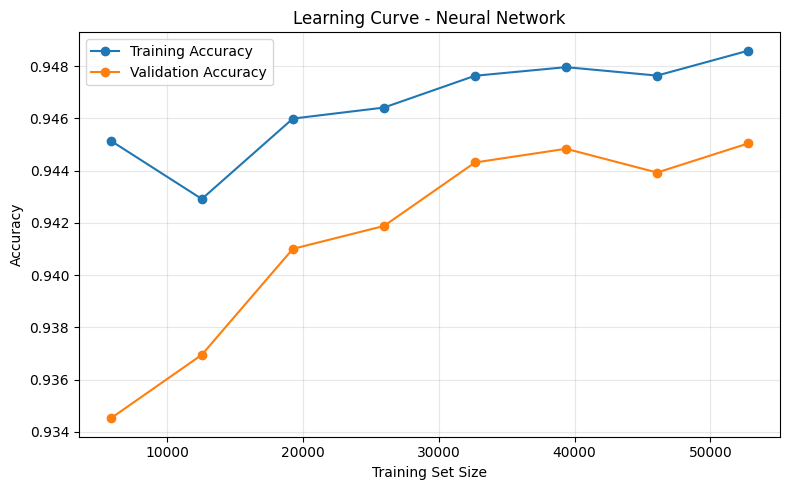

In [ ]:

train_sizes = np.linspace(0.1, 0.9, 8)
train_mean = []
val_mean = []

for frac in train_sizes:
    train_accs = []
    val_accs = []
    for seed in range(3): 
        X_train, X_val, y_train, y_val = train_test_split(
            X, y, train_size=frac, stratify=y, random_state=seed
        )
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        nn = NeuralNetwork(input_shape=X_train.shape[1])
        nn.train(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=0)
        train_accs.append(nn.evaluate(X_train_scaled, y_train))
        val_accs.append(nn.evaluate(X_val_scaled, y_val))
    train_mean.append(np.mean(train_accs))
    val_mean.append(np.mean(val_accs))

plt.figure(figsize=(8,5))
plt.plot(train_sizes * len(X), train_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes * len(X), val_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Neural Network')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Precision

In [ ]:

precision_scores = []
num_runs = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


for train_idx, test_idx in skf.split(X_scaled, y):

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    

    nn = NeuralNetwork(input_shape=X_train.shape[1])
    nn.train(X_train, y_train, epochs=10, batch_size=16, verbose=0)  
    
    y_pred = nn.predict(X_test)
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)

print("Precision scores for each fold:", precision_scores)
print(f"Average precision across {len(precision_scores)} folds: {np.mean(precision_scores):.4f}")
print(f"Standard deviation of precision: {np.std(precision_scores):.4f}")
NN_precision = np.mean(precision_scores)


Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.9044 - loss: 0.2540
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 37s 10ms/step - accuracy: 0.9404 - loss: 0.1890
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9408 - loss: 0.1868
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9446 - loss: 0.1776
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9464 - loss: 0.1765
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 44s 13ms/step - accuracy: 0.9451 - loss: 0.1793
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9458 - loss: 0.1754
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9463 - loss: 0.1722
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9470 - loss: 0.1700
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9494 - loss: 0.1660
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 43s 11ms/step - accuracy: 0.9051 - loss: 0.2581
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 35s 12ms/step - accuracy: 0.9376 - loss: 0.1940
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9414 - loss: 0.1870
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9420 - loss: 0.1817
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - accuracy: 0.9442 - loss: 0.1809
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.9448 - loss: 0.1778
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - accuracy: 0.9451 - loss: 0.1779
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 39s 13ms/step - accuracy: 0.9468 - loss: 0.1726
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9469 - loss: 0.1745
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 38s 13ms/step - accuracy: 0.9461 - loss: 0.1741
367/367 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 41s 12ms/step - accuracy: 0.9061 - loss: 0.2566
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9410 - loss: 0.1876
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step - accuracy: 0.9432 - loss: 0.1841
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9448 - loss: 0.1774
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step - accuracy: 0.9449 - loss: 0.1788
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 46s 13ms/step - accuracy: 0.9453 - loss: 0.1779
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.9465 - loss: 0.1749
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9456 - loss: 0.1751
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9487 - loss: 0.1702
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9473 - loss: 0.1707
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9168 - loss: 0.2443
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9372 - loss: 0.1974
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9403 - loss: 0.1910
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9428 - loss: 0.1852
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9442 - loss: 0.1830
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9439 - loss: 0.1836
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9437 - loss: 0.1816
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9444 - loss: 0.1797
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9448 - loss: 0.1777
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9460 - loss: 0.1748
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9154 - loss: 0.2440
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9388 - loss: 0.1926
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9428 - loss: 0.1845
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9423 - loss: 0.1874
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9440 - loss: 0.1792
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9443 - loss: 0.1790
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9447 - loss: 0.1781
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9472 - loss: 0.1740
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.9460 - loss: 0.1767
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9461 - loss: 0.1726
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Precision scores for each fold: [0.9086460032626428, 0.8781575037147102, 0.91147540983

### Recall

In [ ]:

recall_scores = []
num_runs = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


for train_idx, test_idx in skf.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    nn = NeuralNetwork(input_shape=X_train.shape[1])
    nn.train(X_train, y_train, epochs=10, batch_size=16, verbose=0)
    
    y_pred = nn.predict(X_test)
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)

print("Recall scores for each fold:", recall_scores)
print(f"Average recall across {len(recall_scores)} folds: {np.mean(recall_scores):.4f}")
print(f"Standard deviation of recall: {np.std(recall_scores):.4f}")
NN_recall = np.mean(recall_scores)

Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step - accuracy: 0.9147 - loss: 0.2469
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 932us/step - accuracy: 0.9409 - loss: 0.1905
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.9424 - loss: 0.1833
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 928us/step - accuracy: 0.9443 - loss: 0.1799
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 902us/step - accuracy: 0.9438 - loss: 0.1795
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 909us/step - accuracy: 0.9463 - loss: 0.1756
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - accuracy: 0.9481 - loss: 0.1708
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 921us/step - accuracy: 0.9469 - loss: 0.1740
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 895us/step - accuracy: 0.9469 - loss: 0.1750
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - accuracy: 0.9480 - loss: 0.1707
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 510us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 905us/step - accuracy: 0.9151 - loss: 0.2472
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.9407 - loss: 0.1884
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.9403 - loss: 0.1897
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 929us/step - accuracy: 0.9423 - loss: 0.1868
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - accuracy: 0.9429 - loss: 0.1828
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 903us/step - accuracy: 0.9445 - loss: 0.1776
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step - accuracy: 0.9449 - loss: 0.1781
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - accuracy: 0.9453 - loss: 0.1777
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 914us/step - accuracy: 0.9471 - loss: 0.1744
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.9468 - loss: 0.1764
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 541us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 935us/step - accuracy: 0.9157 - loss: 0.2403
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 944us/step - accuracy: 0.9386 - loss: 0.1927
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step - accuracy: 0.9412 - loss: 0.1848
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 934us/step - accuracy: 0.9418 - loss: 0.1847
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 899us/step - accuracy: 0.9447 - loss: 0.1781
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.9436 - loss: 0.1802
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.9456 - loss: 0.1769
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step - accuracy: 0.9450 - loss: 0.1791
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.9464 - loss: 0.1751
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 922us/step - accuracy: 0.9481 - loss: 0.1712
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 544us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step - accuracy: 0.9087 - loss: 0.2500
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - accuracy: 0.9382 - loss: 0.1943
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.9431 - loss: 0.1848
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.9423 - loss: 0.1847
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 896us/step - accuracy: 0.9432 - loss: 0.1821
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.9461 - loss: 0.1771
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 880us/step - accuracy: 0.9432 - loss: 0.1843
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 916us/step - accuracy: 0.9462 - loss: 0.1777
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 887us/step - accuracy: 0.9446 - loss: 0.1778
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step - accuracy: 0.9456 - loss: 0.1771
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step - accuracy: 0.9066 - loss: 0.2556
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - accuracy: 0.9385 - loss: 0.1919
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 949us/step - accuracy: 0.9391 - loss: 0.1908
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - accuracy: 0.9416 - loss: 0.1852
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 889us/step - accuracy: 0.9421 - loss: 0.1820
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - accuracy: 0.9438 - loss: 0.1816
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.9457 - loss: 0.1767
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.9427 - loss: 0.1813
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 907us/step - accuracy: 0.9453 - loss: 0.1785
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 914us/step - accuracy: 0.9480 - loss: 0.1687
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 549us/step
Recall scores for each fold: [0.6784431137724551, 0.690419161676646

### F1

In [ ]:

f1_scores = []
num_runs = 5
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

for train_idx, test_idx in skf.split(X_scaled, y):

    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    nn = NeuralNetwork(input_shape=X_train.shape[1])
    nn.train(X_train, y_train, epochs=10, batch_size=16, verbose=0)

    y_pred = nn.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

print("F1 scores for each fold:", f1_scores)
print(f"Average F1-score across {len(f1_scores)} folds: {np.mean(f1_scores):.4f}")
print(f"Standard deviation of F1-score: {np.std(f1_scores):.4f}")
NN_F1 = np.mean(f1_scores)

Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - accuracy: 0.9062 - loss: 0.2567
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9396 - loss: 0.1873
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 987us/step - accuracy: 0.9427 - loss: 0.1823
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9444 - loss: 0.1796   
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9431 - loss: 0.1796
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 983us/step - accuracy: 0.9439 - loss: 0.1801
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 986us/step - accuracy: 0.9458 - loss: 0.1758
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 973us/step - accuracy: 0.9484 - loss: 0.1686
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9480 - loss: 0.1701
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 968us/step - accuracy: 0.9470 - loss: 0.1714
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 624us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 985us/step - accuracy: 0.9124 - loss: 0.2496
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 996us/step - accuracy: 0.9381 - loss: 0.1954
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 992us/step - accuracy: 0.9420 - loss: 0.1858
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 956us/step - accuracy: 0.9436 - loss: 0.1831
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.9431 - loss: 0.1829  
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 960us/step - accuracy: 0.9433 - loss: 0.1836
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - accuracy: 0.9438 - loss: 0.1787
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step - accuracy: 0.9458 - loss: 0.1750
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step - accuracy: 0.9447 - loss: 0.1789
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.9477 - loss: 0.1721
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 531us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 885us/step - accuracy: 0.9101 - loss: 0.2484
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - accuracy: 0.9357 - loss: 0.1955
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 912us/step - accuracy: 0.9392 - loss: 0.1916
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step - accuracy: 0.9428 - loss: 0.1801
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.9436 - loss: 0.1807
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - accuracy: 0.9445 - loss: 0.1804
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 910us/step - accuracy: 0.9459 - loss: 0.1765
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - accuracy: 0.9451 - loss: 0.1768
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 920us/step - accuracy: 0.9468 - loss: 0.1756
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 900us/step - accuracy: 0.9478 - loss: 0.1690
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - accuracy: 0.9081 - loss: 0.2579
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 919us/step - accuracy: 0.9378 - loss: 0.1947
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 930us/step - accuracy: 0.9419 - loss: 0.1859
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 927us/step - accuracy: 0.9412 - loss: 0.1850
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.9435 - loss: 0.1821
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 924us/step - accuracy: 0.9440 - loss: 0.1814
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 941us/step - accuracy: 0.9446 - loss: 0.1776
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 946us/step - accuracy: 0.9434 - loss: 0.1838
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 950us/step - accuracy: 0.9467 - loss: 0.1753
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 956us/step - accuracy: 0.9467 - loss: 0.1726
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 530us/step
Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.9132 - loss: 0.2486
Epoch 2/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.9379 - loss: 0.1944
Epoch 3/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 937us/step - accuracy: 0.9409 - loss: 0.1856
Epoch 4/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 940us/step - accuracy: 0.9430 - loss: 0.1849
Epoch 5/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 931us/step - accuracy: 0.9434 - loss: 0.1811
Epoch 6/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 943us/step - accuracy: 0.9437 - loss: 0.1804
Epoch 7/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 926us/step - accuracy: 0.9471 - loss: 0.1728
Epoch 8/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 959us/step - accuracy: 0.9443 - loss: 0.1793
Epoch 9/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.9453 - loss: 0.1767
Epoch 10/10
2933/2933 ━━━━━━━━━━━━━━━━━━━━ 3s 952us/step - accuracy: 0.9455 - loss: 0.1782
367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 548us/step
F1 scores for each fold: [0.768081494057725, 0.78852798894264, 0.76

### Confusion Matrix

Epoch 1/10


c:\Users\diana\OneDrive\Documentos\uni\3ano_2semestre\ia\IA_project2\.venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 904us/step - accuracy: 0.9005 - loss: 0.2632
Epoch 2/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 955us/step - accuracy: 0.9394 - loss: 0.1941
Epoch 3/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 933us/step - accuracy: 0.9404 - loss: 0.1863
Epoch 4/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step - accuracy: 0.9433 - loss: 0.1824
Epoch 5/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 913us/step - accuracy: 0.9420 - loss: 0.1844
Epoch 6/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 901us/step - accuracy: 0.9452 - loss: 0.1778
Epoch 7/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 911us/step - accuracy: 0.9453 - loss: 0.1783
Epoch 8/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 917us/step - accuracy: 0.9425 - loss: 0.1831
Epoch 9/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 925us/step - accuracy: 0.9461 - loss: 0.1755
Epoch 10/10
2749/2749 ━━━━━━━━━━━━━━━━━━━━ 3s 918us/step - accuracy: 0.9473 - loss: 0.1716
459/459 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step


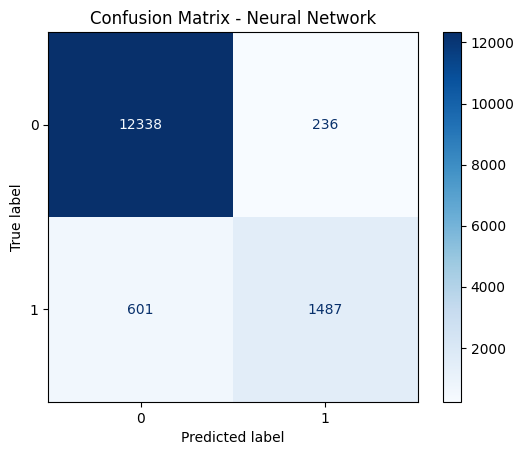

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nn = NeuralNetwork(input_shape=X_train.shape[1])
nn.train(X_train_scaled, y_train, epochs=10, batch_size=16, verbose=0)

y_pred = nn.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Neural Network")
plt.show()

# ----------------------------------------------------------------------
#### Support Vector Machines (SVM)

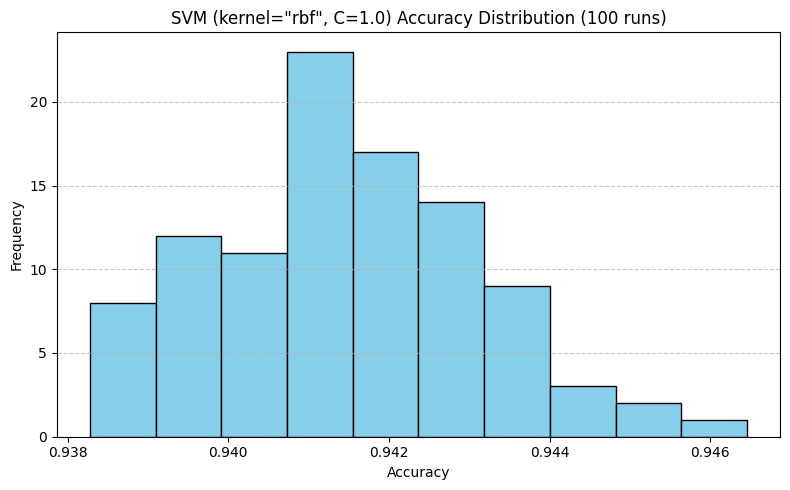

Average Accuracy over 100 runs: 0.9414


In [79]:
# SVM with basic train-test split
kernel = 'rbf' 
C = 1.0

model_accuracies = []

for repetition in range(100):
    training_inputs, testing_inputs, training_classes, testing_classes = train_test_split(
        all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=repetition
    )

    # Normalize the data
    scaler = StandardScaler()
    training_inputs_scaled = scaler.fit_transform(training_inputs)
    testing_inputs_scaled = scaler.transform(testing_inputs)

    # Train the SVM classifier
    svm_classifier = SVC(kernel=kernel, C=C, random_state=1)
    svm_classifier.fit(training_inputs_scaled, training_classes)

    # Predict and evaluate
    predicted_classes = svm_classifier.predict(testing_inputs_scaled)
    model_accuracies.append(accuracy_score(testing_classes, predicted_classes))

# Plot accuracy distribution
plt.figure(figsize=(8, 5))
plt.hist(model_accuracies, bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'SVM (kernel="{kernel}", C={C}) Accuracy Distribution (100 runs)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Average Accuracy over 100 runs: {sum(model_accuracies) / len(model_accuracies):.4f}')

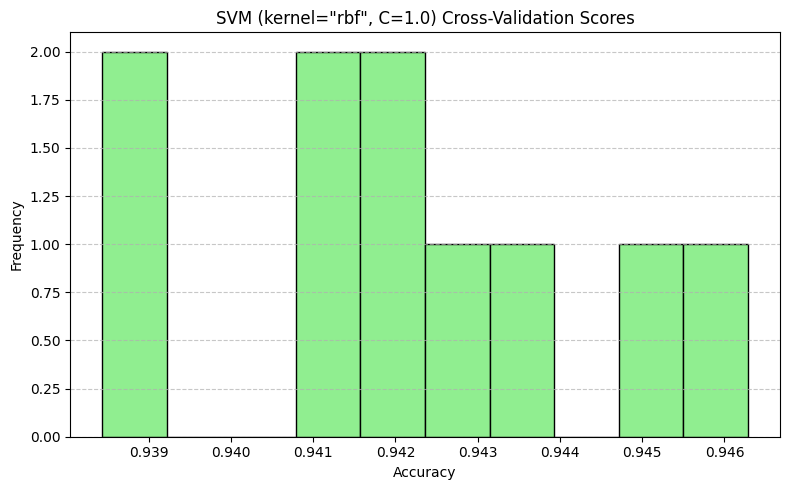

Cross-Validation Scores: [0.94134697 0.94526854 0.943052   0.94168798 0.94390452 0.9462824
 0.94167804 0.9415075  0.93894952 0.93843793]
Average accuracy across 10 folds: 0.9422


In [ ]:
# SVM with Stratified K-Fold Cross-Validation
kernel = 'rbf'
C = 1.0

# Stratified K-Fold Cross-Validation
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
svm_classifier = SVC(kernel=kernel, C=C, random_state=1)

cv_scores = cross_val_score(svm_classifier, all_inputs_scaled, all_labels, cv=stratified_kfold, scoring='accuracy')

# Plot cross-validation scores
plt.figure(figsize=(8, 5))
plt.hist(cv_scores, bins=10, color='lightgreen', edgecolor='black')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title(f'SVM (kernel="{kernel}", C={C}) Cross-Validation Scores')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f'Cross-Validation Scores: {cv_scores}')
print(f'Average accuracy across 10 folds: {np.mean(cv_scores):.4f}')
SVM_score = np.mean(cv_scores)

### Statistics
### Plot Roc Curve 

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    all_inputs_scaled, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

svm_with_proba = SVC(kernel=kernel, C=C, probability=True, random_state=1)
svm_with_proba.fit(X_train, y_train)

y_proba = svm_with_proba.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
SVM_auc = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'SVM ROC (AUC = {SVM_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


NameError: name 'all_inputs_scaled' is not defined


### Precision

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
precision_scores = []

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

for train_idx, test_idx in cv.split(all_inputs_scaled, all_labels):

    X_train, X_test = all_inputs_scaled[train_idx], all_inputs_scaled[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    
    precision = precision_score(y_test, y_pred)
    precision_scores.append(precision)

print("Precision scores for each fold:", precision_scores)
print(f"Average precision across folds: {np.mean(precision_scores):.4f}")
print(f"Standard deviation of precision: {np.std(precision_scores):.4f}")

SVM_precision = np.mean(precision_scores)

Precision scores for each fold: [0.9019607843137255, 0.8919382504288165, 0.9016129032258065, 0.9136212624584718, 0.8986710963455149, 0.9279731993299832, 0.9188741721854304, 0.912, 0.9119601328903655, 0.8929133858267716]
Average precision across folds: 0.9072
Standard deviation of precision: 0.0111


### Recall

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
recall_scores = []

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

for train_idx, test_idx in cv.split(all_inputs_scaled, all_labels):
    X_train, X_test = all_inputs_scaled[train_idx], all_inputs_scaled[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    
    recall = recall_score(y_test, y_pred)
    recall_scores.append(recall)

print("Recall scores for each fold:", recall_scores)
print(f"Average recall across folds: {np.mean(recall_scores):.4f}") 
print(f"Standard deviation of recall: {np.std(recall_scores):.4f}")
SVM_recall = np.mean(recall_scores)

Recall scores for each fold: [0.6610778443113773, 0.6227544910179641, 0.6694610778443114, 0.6586826347305389, 0.6479041916167665, 0.6634730538922156, 0.6646706586826348, 0.6826347305389222, 0.6574850299401198, 0.6790419161676646]
Average recall across folds: 0.6607
Standard deviation of recall: 0.0159


### F1

In [ ]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
f1_scores = []

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)

scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

for train_idx, test_idx in cv.split(all_inputs_scaled, all_labels):
    X_train, X_test = all_inputs_scaled[train_idx], all_inputs_scaled[test_idx]
    y_train, y_test = all_labels[train_idx], all_labels[test_idx]
    
    svm_classifier.fit(X_train, y_train)
    y_pred = svm_classifier.predict(X_test)
    
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

print("F1 scores for each fold:", f1_scores)
print(f"Average F1-score across folds: {np.mean(f1_scores):.4f}")
print(f"Standard deviation of F1-score: {np.std(f1_scores):.4f}")
SVM_F1 = np.mean(f1_scores)

F1 scores for each fold: [0.7629578438147893, 0.7334273624823695, 0.768384879725086, 0.7654836464857342, 0.7529575504523313, 0.7737430167597765, 0.7713690062543433, 0.7808219178082192, 0.7640918580375783, 0.7714285714285715]
Average F1-score across folds: 0.7645
Standard deviation of F1-score: 0.0125


### Confusion Matrix

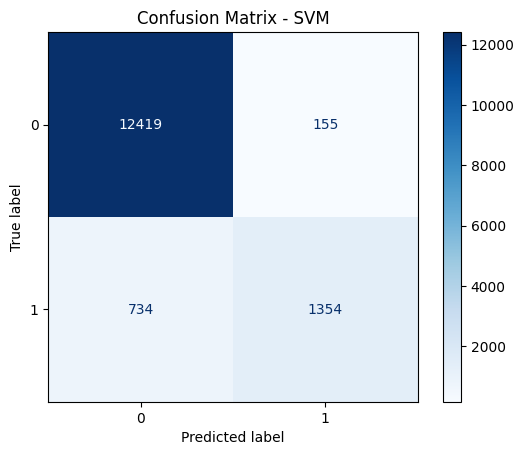

In [ ]:

X_train, X_test, y_train, y_test = train_test_split(
    all_inputs, all_labels, test_size=0.25, stratify=all_labels, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_classifier = SVC(kernel='rbf', C=1.0, random_state=42)
svm_classifier.fit(X_train_scaled, y_train)

y_pred = svm_classifier.predict(X_test_scaled)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SVM")
plt.show()

In [1]:
results = {
    'DecisionTree_precision': DecisionTree_precision,
    'DecisionTree_recall': DecisionTree_recall,
    'DecisionTree_f1_score': DecisionTree_F1,
    'DecisionTree_accuracy': DecisionTree_bestScore,
    'DecisionTree_auc' : DecisionTree_auc,
    'RandomForest_precision': RandomForest_precision,
    'RandomForest_recall': RandomForest_recall,
    'RandomForest_f1_score': RandomForest_F1,
    'RandomForest_accuracy': RandomForest_score,
    'RandomForest_auc' : RandomForest_auc,
    'AdaBoost_precision': AdaBoost_precision,
    'AdaBoost_recall': AdaBoost_recall,
    'AdaBoost_f1_score': AdaBoost_F1,
    'AdaBoost_accuracy': AdaBoost_score,
    'AdaBoost_auc' : AdaBoost_auc,
    'XGBoost_precision': XGBoost_score,
    'XGBoost_recall': 0,
    'XGBoost_f1_score': 0,
    'XGBoost_accuracy': 0,
    'XGBoost_auc' : XGBoost_auc,
    'NN_precision': NN_precision,
    'NN_recall': NN_recall,
    'NN_f1_score': NN_F1,
    'NN_accuracy': NN_score,
    'NN_auc' : NN_auc,
    'Knn_precision': Knn_precision,
    'Knn_recall': Knn_recall,
    'Knn_f1_score': Knn_F1,
    'Knn_accuracy': Knn_score,
    'Knn_auc' : Knn_auc,
    'SVM_precision': SVM_precision,
    'SVM_recall': SVM_recall,
    'SVM_f1_score': SVM_F1,
    'SVM_accuracy': SVM_score,
    'SVM_auc' : SVM_auc,
}

NameError: name 'DecisionTree_precision' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class AlgorithmComparisonVisualizer:
    def __init__(self, data_dict=None):
        self.data = data_dict
        self.df = self._create_dataframe()
    
    
    def _create_dataframe(self):
        rows = []
        for key, value in self.data.items():
            algorithm, metric = key.split('_', 1)
            rows.append({
                'Algorithm': algorithm,
                'Metric': metric,
                'Value': value
            })
        return pd.DataFrame(rows)
    
    def plot_grouped_bar_chart(self, figsize=(12, 8)):
            plt.figure(figsize=figsize)
            
            pivot_df = self.df.pivot(index='Metric', columns='Algorithm', values='Value')
            
            ax = pivot_df.plot(kind='bar', width=0.8)
            plt.title('Performance Comparison by Metric and Algorithm', fontsize=16, fontweight='bold')
            plt.xlabel('Metrics', fontsize=12)
            plt.ylabel('Values', fontsize=12)
            plt.legend(title='Algorithms', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.xticks(rotation=45)
            plt.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            for container in ax.containers:
                ax.bar_label(container, fmt='%.3f', rotation=90, fontsize=8)
            
            plt.show()
    
    def plot_heatmap(self, figsize=(10, 6)):
        plt.figure(figsize=figsize)

        pivot_df = self.df.pivot(index='Algorithm', columns='Metric', values='Value')
        
        sns.heatmap(pivot_df, annot=True, cmap='YlOrRd', fmt='.3f', 
                   cbar_kws={'label': 'Metric value'})
        plt.title('Heatmap of Performance', fontsize=16, fontweight='bold')
        plt.xlabel('Metric', fontsize=12)
        plt.ylabel('Algorithm', fontsize=12)
        plt.tight_layout()
        plt.show()
    
    def plot_radar_chart(self, figsize=(12, 8)):
        algorithms = self.df['Algorithm'].unique()
        metrics = self.df['Metric'].unique()

        angles = np.linspace(0, 2 * np.pi, len(metrics), endpoint=False).tolist()
        angles += angles[:1] 
        
        fig, ax = plt.subplots(figsize=figsize, subplot_kw=dict(projection='polar'))
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(algorithms)))
        
        for i, algorithm in enumerate(algorithms):
            values = []
            for metric in metrics:
                value = self.df[(self.df['Algorithm'] == algorithm) & 
                               (self.df['Metric'] == metric)]['Value'].iloc[0]
                values.append(value)
            
            values += values[:1] 
            
            ax.plot(angles, values, 'o-', linewidth=2, label=algorithm, color=colors[i])
            ax.fill(angles, values, alpha=0.25, color=colors[i])
        
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(metrics)
        ax.set_ylim(0, 1)
        ax.set_title('Algorithm Radar Comparison', fontsize=16, fontweight='bold', pad=20)
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def plot_algorithm_comparison(self, figsize=(12, 8)):
        plt.figure(figsize=figsize)

        pivot_df = self.df.pivot(index='Algorithm', columns='Metric', values='Value')
        
        ax = pivot_df.plot(kind='bar', width=0.8)
        plt.title('Algorithm Comparison by Metric', fontsize=16, fontweight='bold')
        plt.xlabel('Algorithms', fontsize=12)
        plt.ylabel('Values', fontsize=12)
        plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.xticks(rotation=45)
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        for container in ax.containers:
            ax.bar_label(container, fmt='%.3f', rotation=90, fontsize=8)
        
        plt.show()
    
    def generate_all_charts(self):
        self.plot_grouped_bar_chart()
        self.plot_algorithm_comparison()
        self.plot_heatmap()
        self.plot_radar_chart()
        
    

visualizer = AlgorithmComparisonVisualizer(results)
visualizer.generate_all_charts()